In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
import healpy as hp

length of sdss lrg array:  4851200
length of lrg only array: 1406221
length of row matched targets in SDSS and DECaLS:  4851200
length of DECaLS targets in brick:  4529240
length of id_ALL:  4529240
length of id_MATCHED with LRG_cut (id_LRG): 1528
length of idcut: 4529240
length of idcut = 1 (is an LRG in DECaLS-only file): 1151
length of idcut = 0 (is not an LRG in DECaLS-only file): 4528089
length of z_lrg: 1151
LRGs only
length gobs: 1151
length robs; 1151
length gflux: 1151
length rflux: 1151
length of gmag array =  1151
shape of gmag array: (1151,)
length of rmag array =  1151
length of zmag array =  1151
length of color array =  1151
Max gmag =  23.8119
Min gmag =  16.1883
Max rmag =  21.9023
Min rmag =  15.6875
Max zmag =  20.9979
Min zmag =  14.9612
Min color =  -0.47049
Max color =  2.7235

Background only
length gobs: 413033
length robs: 413033
length gflux: 413033
length rflux: 413033
length of gmag array =  413033
shape of gmag array: (1151,)
length of rmag array =  413033


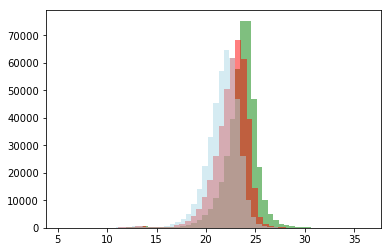



Only LRGs
Max z =  7.05564
Min z =  -0.0118664
shape of z_lrg: (1151, 1)


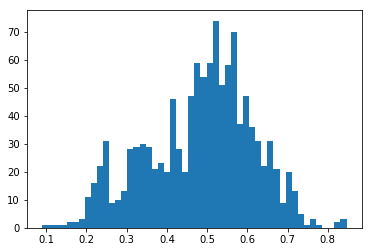

In [2]:
# Reading in data and assigning it to variables even though Greg seems to think it's a waste of time.

# Read in data
# hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits') # survey
# hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
# tbdata = hdulist[1].data
# tbdata2 = hdulist2[1].data

hdulist = fits.open('/Users/mtownsend/anaconda/Data/survey-dr5-specObj-dr14.fits') # this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS AND DECALS
hdulist2 = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdulist3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010.fits') # this is one sweep file of the 
                                                                                  # DECaLS data
SpecObj_data = hdulist[1].data
SDSS_data = hdulist2[1].data
DECaLS_data = hdulist3[1].data

# print(len(SpecObj_data))
# print(len(SDSS_data))
# print(len(DECaLS_data))

# Put data in arrays

# Read in data from SDSS file

# Redshift of galaxies according to sdss
z = []
z = SDSS_data.field('Z') 

# Class of object
gal_class = []
gal_class = SDSS_data.field('CLASS')

# What survey the data is from
survey = []
survey = SDSS_data.field('SURVEY')

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = SDSS_data.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = SDSS_data.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = SDSS_data.field('CLASS_NOQSO')

# Array for LRG targets
targets = []
targets = SDSS_data.field('BOSS_TARGET1')

# Section of code to find LRG targets

def divideBy2(decNumber):

	# from pythonds.basic.stack import Stack
# 	import numpy as np

	np.vectorize(decNumber)  
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString
	
	
	
# Function to find LOWZ targets
divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form

b = []
c = []

for i in range(len(a)):
	b.append(list((a[i])))
	b[i].reverse()
	
# print(b)

lrg = []

# Finds flags for BOSS LOWZ and CMASS sample
for i in range(len(b)):
	try:
		if (b[i][0] == '1') or (b[i][1] == '1'):
			lrg.append(int(1))
		else:
			lrg.append(int(0))
	except IndexError:
		pass
# 		print('pass statement')
		lrg.append(int(0))
		
lrg = np.array(lrg)
print('length of sdss lrg array: ', len(lrg))
print('length of lrg only array:', len(lrg[np.where(lrg == 1)]))

# ------------------------------------------------------------------------------------------------------------

# Read in data from SDSS row matched DECaLS file

# Object ID from survey file; value -1 for non-matches
objid_MATCHED = []
objid_MATCHED = SpecObj_data.field('OBJID')
# print(len(objid_LRG))
# print(type(objid_LRG[1]))

# Add bridkid
brickid_MATCHED = []
brickid_MATCHED = SpecObj_data.field('BRICKID')
# print(len(brickid_LRG))

# Add brickname
brickname_MATCHED = []
brickname_MATCHED = SpecObj_data.field('BRICKNAME')

# Only galaxies included
gal_type_MATCHED = []
gal_type_MATCHED = SpecObj_data.field('TYPE') 

# RA
ra_MATCHED = []
ra_MATCHED = SpecObj_data.field('RA')

# Dec
dec_MATCHED = []
dec_MATCHED = SpecObj_data.field('DEC')

# flux_g
gflux_MATCHED = []
gflux_MATCHED = SpecObj_data.field('FLUX_G')

# flux_r
rflux_MATCHED = []
rflux_MATCHED = SpecObj_data.field('FLUX_R')

# flux_z
zflux_MATCHED = []
zflux_MATCHED = SpecObj_data.field('FLUX_Z')

# nobs == number of images that contribute to the central pixel
# nobs_g
gobs_MATCHED = []
gobs_MATCHED = SpecObj_data.field('NOBS_G')

# nobs_r
robs_MATCHED = []
robs_MATCHED = SpecObj_data.field('NOBS_R')

# nobs_z
zobs_MATCHED = []
zobs_MATCHED = SpecObj_data.field('NOBS_Z')

# Create a unique identifier by combinding BRICKID and OBJID

id_MATCHED = []

for i in range(len(objid_MATCHED)):
    if (objid_MATCHED[i] == -1):
        id_MATCHED.append(-1)
    else:
        temp1 = str(brickid_MATCHED[i]) + str(objid_MATCHED[i])
        id_MATCHED.append(temp1)

print('length of row matched targets in SDSS and DECaLS: ', len(id_MATCHED)) 
id_MATCHED = np.array(id_MATCHED)
# ------------------------------------------------------------------------------------------------------------

# Read in data from DECaLS bricks

# Object ID from survey file; value -1 for non-matches
objid_ALL = []
objid_ALL = DECaLS_data.field('OBJID')
# print(len(objid_ALL))

# Add bridkid
brickid_ALL = []
brickid_ALL = DECaLS_data.field('BRICKID')
# print(len(brickid_ALL))

# Add brickname
brickname_ALL = []
brickname_ALL = DECaLS_data.field('BRICKNAME')

# Only galaxies included
gal_type_ALL = []
gal_type_ALL = DECaLS_data.field('TYPE') 

# RA
ra_ALL = []
ra_ALL = DECaLS_data.field('RA')

# Dec
dec_ALL = []
dec_ALL = DECaLS_data.field('DEC')

# flux_g
gflux_ALL = []
gflux_ALL = DECaLS_data.field('FLUX_G')

# flux_r
rflux_ALL = []
rflux_ALL = DECaLS_data.field('FLUX_R')

# flux_z
zflux_ALL = []
zflux_ALL = DECaLS_data.field('FLUX_Z')

# nobs == number of images that contribute to the central pixel
# nobs_g
gobs_ALL = []
gobs_ALL = DECaLS_data.field('NOBS_G')

# nobs_r
robs_ALL = []
robs_ALL = DECaLS_data.field('NOBS_R')

# nobs_z
zobs_ALL = []
zobs_ALL = DECaLS_data.field('NOBS_Z')

id_ALL = []

for i in range(len(objid_ALL)):
    temp2 = str(brickid_ALL[i]) + str(objid_ALL[i])
    id_ALL.append(temp2)
    
print('length of DECaLS targets in brick: ', len(id_ALL))

id_ALL = np.array(id_ALL)

print('length of id_ALL: ', len(id_ALL))

# ------------------------------------------------------------------------------------------------------------

# Make cuts to separate LRGs and background galaxies

# Selects only LRGs (with other cuts)
LRG_cut = ((gobs_MATCHED >= 3.) & (robs_MATCHED >= 3.) & (zobs_MATCHED >= 3) & (gflux_MATCHED > 0.) & (rflux_MATCHED > 0.) &(zflux_MATCHED > 0.) & (objid_MATCHED > -1) & (lrg == 1) & ((gal_type_MATCHED == 'SIMP') | (gal_type_MATCHED == "DEV") | (gal_type_MATCHED == "EXP") | (gal_type_MATCHED == "REX")) & (ra_MATCHED >= 241) & (ra_MATCHED <= 246) & (dec_MATCHED >= 6.5) & (dec_MATCHED <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))

id_LRG = []
id_LRG = np.array(id_LRG)
id_LRG = id_MATCHED[np.where(LRG_cut)]
print('length of id_MATCHED with LRG_cut (id_LRG):', len(id_LRG))

idcut = []

# This creates a list that is the length of id_ALL that matches LRGs from the DECaLS/SDSS file to the DECaLS file
# Use id_cut_noLRG == 0 to get galaxy sources that are NOT identified LRGs 
# For use in narrowing down DECaLS-only file (ie 'ALL')
for i in range(len(id_ALL)):
    if any(id_LRG == id_ALL[i]):
        idcut.append(1)
    else:
        idcut.append(0)

idcut = np.array(idcut)
print('length of idcut:', len(idcut))
print('length of idcut = 1 (is an LRG in DECaLS-only file):', len(idcut[np.where(idcut == 1)]))
print('length of idcut = 0 (is not an LRG in DECaLS-only file):', len(idcut[np.where(idcut == 0)]))

# idcut1 = idcut[np.where(idcut == 1)] 

z_lrg = []
ra_lrg = []
dec_lrg = []
for i in range(len(id_ALL)):
    if (idcut[i] == 1):
        z_lrg.append(z[np.where(id_MATCHED == id_ALL[i])])
        ra_lrg.append(ra_MATCHED[np.where(id_MATCHED == id_ALL[i])])
        dec_lrg.append(dec_MATCHED[np.where(id_MATCHED == id_ALL[i])])

print('length of z_lrg:', len(z_lrg))
z_lrg = np.array(z_lrg)
z_LRG = np.concatenate(z_lrg)
ra_lrg = np.array(ra_lrg)
ra_LRG = np.concatenate(ra_lrg)
dec_lrg = np.array(dec_lrg)
dec_LRG = np.concatenate(dec_lrg)

# LRG_cut = ((id_cut_LRG == 1) & (gobs_MATCHED >= 3.) & (robs_MATCHED >= 3.) & (gflux_MATCHED > 0.) & (rflux_MATCHED > 0.) & (objid_MATCHED > -1) & (lrg == 1) & ((gal_type_MATCHED == 'SIMP') | (gal_type_MATCHED == "DEV") | (gal_type_MATCHED == "EXP") | (gal_type_MATCHED == "REX")) & (ra_MATCHED >= 241) & (ra_MATCHED <= 246) & (dec_MATCHED >= 6.5) & (dec_MATCHED <= 11.5) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss')))
# & (brickid_LRG == brickid_ALL)
# print(len(LOWZ_cut))

# Cut out LRGs
no_LRG_cut = ((idcut == 0) & (gobs_ALL >= 3.) & (robs_ALL >= 3.) & (zobs_ALL >= 3.) & (gflux_ALL > 0.) & (rflux_ALL > 0.) & (zflux_ALL > 0.) & ((gal_type_ALL == 'SIMP') | (gal_type_ALL == "DEV") | (gal_type_ALL == "EXP") | (gal_type_ALL == "REX")) & (ra_ALL >= 241) & (ra_ALL <= 246) & (dec_ALL >= 6.5) & (dec_ALL <= 11.5))

# Flux cuts

# Flux in g for only LRGs
gflux_LRG = gflux_ALL[np.where(idcut == 1)]

# Flux in r for only LRGs
rflux_LRG = rflux_ALL[np.where(idcut == 1)]

# Flux in g for only LRGs
zflux_LRG = zflux_ALL[np.where(idcut == 1)]

# Flux in g for all galaxies in DECaLS
gflux_BKG = gflux_ALL[np.where(no_LRG_cut)]

# Flux in r for all galaxies in DECaLS
rflux_BKG = rflux_ALL[np.where(no_LRG_cut)]

# Flux in z for all galaxies in DECaLS
zflux_BKG = zflux_ALL[np.where(no_LRG_cut)]


# Obs cuts

# Number of images in g for only LRGs
gobs_LRG = gobs_ALL[np.where(idcut == 1)]

# Number of images in r for only LRGs
robs_LRG = robs_ALL[np.where(idcut == 1)]

# Number of images in g for only LRGs
zobs_LRG = zobs_ALL[np.where(idcut == 1)]

# Number of images in g for all galaxies in DECaLS
gobs_BKG = gobs_ALL[np.where(no_LRG_cut)]

# Number of images in r for all galaxies in DECaLS
robs_BKG = robs_ALL[np.where(no_LRG_cut)]

# Number of images in z for all galaxies in DECaLS
zobs_BKG = zobs_ALL[np.where(no_LRG_cut)]

print('LRGs only')
print('length gobs:', len(gobs_LRG))
print('length robs;', len(robs_LRG))
print('length gflux:', len(gflux_LRG))
print('length rflux:', len(rflux_LRG))

gmag_LRG = 22.5 - 2.5 * np.log10(gflux_LRG)
rmag_LRG = 22.5 - 2.5 * np.log10(rflux_LRG)
zmag_LRG = 22.5 - 2.5 * np.log10(zflux_LRG)

color_LRG = gmag_LRG - rmag_LRG

print("length of gmag array = ", len(gmag_LRG))
print('shape of gmag array:', gmag_LRG.shape)
print("length of rmag array = ",len(rmag_LRG))
print("length of zmag array = ",len(zmag_LRG))
print("length of color array = ", len(color_LRG))
print("Max gmag = ", np.amax(gmag_LRG))
print("Min gmag = ", np.amin(gmag_LRG))
print("Max rmag = ", np.amax(rmag_LRG))
print("Min rmag = ", np.amin(rmag_LRG))
print("Max zmag = ", np.amax(zmag_LRG))
print("Min zmag = ", np.amin(zmag_LRG))
print("Min color = ", np.amin(color_LRG))
print("Max color = ", np.amax(color_LRG))
print("")
print('Background only')
print('length gobs:', len(gobs_BKG))
print('length robs:', len(robs_BKG))
print('length gflux:', len(gflux_BKG))
print('length rflux:', len(rflux_BKG))

gmag_BKG = 22.5 - 2.5 * np.log10(gflux_BKG)
rmag_BKG = 22.5 - 2.5 * np.log10(rflux_BKG)
zmag_BKG = 22.5 - 2.5 * np.log10(zflux_BKG)

color_BKG = gmag_BKG - rmag_BKG

print("length of gmag array = ", len(gmag_BKG))
print('shape of gmag array:', gmag_LRG.shape)
print("length of rmag array = ",len(rmag_BKG))
print("length of zmag array = ",len(zmag_BKG))
print("length of color array = ", len(color_BKG))
print("Max gmag = ", np.amax(gmag_BKG))
print("Min gmag = ", np.amin(gmag_BKG))
print("Max rmag = ", np.amax(rmag_BKG))
print("Min rmag = ", np.amin(rmag_BKG))
print("Max zmag = ", np.amax(zmag_BKG))
print("Min zmag = ", np.amin(zmag_BKG))
print("Min color = ", np.amin(color_BKG))
print("Max color = ", np.amax(color_BKG))

plt.hist(gmag_BKG, bins=50, color='green', alpha=0.5)
plt.hist(rmag_BKG, bins=50, color='red', alpha=0.5)
plt.hist(zmag_BKG, bins=50, color='lightblue', alpha=0.5)
plt.show()

print("")
# Only LRGs
print("")
print("Only LRGs")
print("Max z = ", np.amax(z))
print("Min z = ", np.amin(z))
print('shape of z_lrg:', z_lrg.shape)
plt.hist(z_LRG, bins=50)
plt.show()

In [3]:
# cosmoCalc function to find scale (kpc_DA)
# This is a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# I know this isn't ideal but for some reason the function won't import, even though it imports just fine in other
# files in the same directory

def cosmoCalcfunc(z):
    import numpy as np
    from math import sqrt
    from math import exp
    from math import sin
    from math import pi

# Calculate scale to get areas
    H0 = 69.6
    WM = 0.286
    WV = 0.714
# z = 0.209855

# initialize constants

    WR = 0.        # Omega(radiation)
    WK = 0.        # Omega curvaturve = 1-Omega(total)
    c = 299792.458 # velocity of light in km/sec
    Tyr = 977.8    # coefficent for converting 1/H into Gyr
    DTT = 0.5      # time from z to now in units of 1/H0
    DTT_Gyr = []  # value of DTT in Gyr
    age = 0.5      # age of Universe in units of 1/H0
    age_Gyr = []  # value of age in Gyr
    zage = 0.1     # age of Universe at redshift z in units of 1/H0
    zage_Gyr = [] # value of zage in Gyr
    DCMR = 0.0     # comoving radial distance in units of c/H0
    DCMR_Mpc = [] 
    DCMR_Gyr = []
    DA = 0.0       # angular size distance
    DA_Mpc = []
    DA_Gyr = []
    kpc_DA = []
    DL = 0.0       # luminosity distance
    DL_Mpc = []
    DL_Gyr = []   # DL in units of billions of light years
    V_Gpc = []
    a = 1.0        # 1/(1+z), the scale factor of the Universe
    az = 0.5       # 1/(1+z(object))

    h = H0/100.
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV

    for j in range(len(z)):
        az = 1.0/(1+1.0*z[j])
        age = 0.
        n=1000         # number of points in integrals
        for i in range(n):
            a = az*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            age = age + 1./adot

        zage = az*age/n
        zage_Gyr.append((Tyr/H0)*zage)
        DTT = 0.0
        DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
        for i in range(n):
            a = az+(1-az)*(i+0.5)/n
            adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
            DTT = DTT + 1./adot
            DCMR = DCMR + 1./(a*adot)

        DTT = (1.-az)*DTT/n
        DCMR = (1.-az)*DCMR/n
        age = DTT+zage
        age_Gyr.append(age*(Tyr/H0))
        DTT_Gyr.append((Tyr/H0)*DTT)
        DCMR_Gyr.append((Tyr/H0)*DCMR)
        DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio =  0.5*(exp(x)-exp(-x))/x 
            else:
                ratio = sin(x)/x
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/6. + y*y/120.
        DCMT = ratio*DCMR
        DA = az*DCMT
        DA_Mpc.append((c/H0)*DA)
        kpc_DA.append(DA_Mpc[j]/206.264806)
        DA_Gyr.append((Tyr/H0)*DA)
        DL = DA/(az*az)
        DL_Mpc.append((c/H0)*DL)
        DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

        ratio = 1.00
        x = sqrt(abs(WK))*DCMR
        if x > 0.1:
            if WK > 0:
                ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
            else:
                ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
        else:
            y = x*x
            if WK < 0: y = -y
            ratio = 1. + y/5. + (2./105.)*y*y
        VCM = ratio*DCMR*DCMR*DCMR/3.
        V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
        
    return(DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc)

DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

H:
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.00000000e+00   4.80000000e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.80000000e+01   8.89000000e+02   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.60000000e+01   1.65600000e+03   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.85000000e+02   5.46300000e+03   4.60000000e+01   3.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   8.00000000e+00
    7.67000000e+02   6.45790000e+04   2.17000000e+02   1.80000000e+01
    5.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.40000000e+01
    1.06460000e+04   2.60682000e+05   7.16

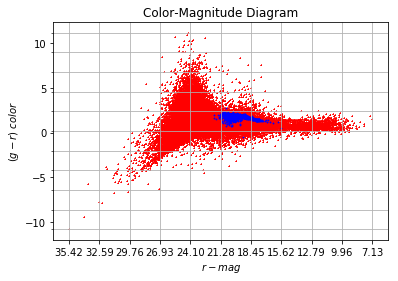

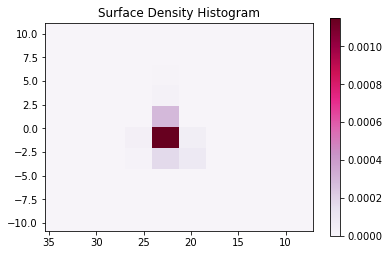

In [4]:
# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin. H is the matrix 
# with the number of points per bin. Uses this number to calculate the surface density, by dividing the number
# of sources per bin by the area of the EDR. (This is done for every bin.)

# Histogram in color-magnitude space

# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin
# H is the matrix with the number of points per bin
# xedges, yedges are the bounds of the bins
row = 10
column = 10
# creates histogram for survey sources; excludes LRGs
H, xedges, yedges = np.histogram2d(rmag_BKG, color_BKG, normed=False)
print("H:")
print(H)
print('-------')
print('shape H')
print(np.shape(H))

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of sources
# divided by the area 
sd = H/(17.5 * (3600.**2.)) # converts 25 square degrees to square arcseconds
print("sd:")
print(sd)
print('-------')

# Scatter plot of points with bin lines drawn
fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag_BKG, color_BKG, s = 1, marker = '+', color='red')
plt.scatter(rmag_LRG, color_LRG, s = 1, marker = '*', color='blue')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.show()

# color codes bins by surface density with color bar; should make sense when compared to scatter plot
plt.imshow(sd, cmap=plt.cm.PuRd, extent=(xedges[0], xedges[len(xedges)-1], yedges[0], yedges[len(yedges)-1]))
plt.colorbar(orientation='vertical')
plt.gca().invert_xaxis()
plt.title("Surface Density Histogram")
plt.show()

<class 'numpy.ndarray'>
length ra_lrg: 1151
length dec_lrg: 1151
length ra_BKG: 413033
length dec_BKG: 413033
length dist: 1151
<class 'list'>


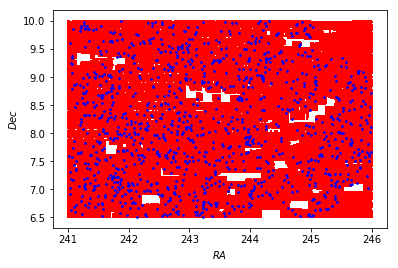

len zip_list_LRG 1151


In [5]:
# Counting NEAR NEIGHBORS (nn) using KDTree
# Result is an array of the number of near neighbors each LRG has

ra_BKG = ra_ALL[np.where(no_LRG_cut)]
dec_BKG = dec_ALL[np.where(no_LRG_cut)]

# ra_lrg = np.array(ra_lrg)
# dec_lrg = np.array(dec_lrg)

# ra_LRG = np.concatenate(ra_lrg)
# print(type(ra_lrg))
# dec_LRG = np.concatenate(dec_lrg)
# print(type(dec_lrg))
# ra_BKG = list(ra_BKG)
print(type(ra_BKG))
# dec_BKG = list(dec_BKG)
# print(type(dec_BKG))

print("length ra_lrg:", len(ra_LRG))
print("length dec_lrg:", len(dec_LRG))
print("length ra_BKG:", len(ra_BKG))
print("length dec_BKG:", len(dec_BKG))

# Distance from which we are looking for satellites around the LRGs
distance = 0.5 # in Mpc
distance_kpc = distance * 10.**3. # in kpc

dist = []
for i in range(len(kpc_DA)):
    dist.append((distance_kpc / kpc_DA[i]) * 1./3600.) 
    
# dist = np.concatenate(dist)
print('length dist:', len(dist))

print(type(dist))    
# Plot RA/Dec plot with circles around LRGs
# Plots LRG sources and EDR sources
plt.scatter(ra_BKG, dec_BKG, s = 3, marker = '+', color='red')
plt.scatter(ra_LRG, dec_LRG, s = 3, marker = 'o', color='blue')
# Draws circle of some radius around the LRG sources
# Circles too small to really see in the plot, but I have tested it with bigger radii to make sure it works if I
# ever need it.
# circle = []
# for i in range(len(ra_LRG)):
#     circle = plt.Circle((ra_LRG[i],dec_LRG[i]), dist[i], color='green', fill=False)
#     plt.gcf().gca().add_artist(circle)

plt.xlabel(r'$RA$')
plt.ylabel(r'$Dec$')
plt.show()

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_LRG = list(zip(ra_LRG, dec_LRG)) # Fake LRG sources
zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # Fake EDR sources
# print(zip_list_lrg)
# print(type(zip_list_BKG))
# print(zip_list_LRG[0])
# print(type(zip_list_LRG[0]))
# print(type(zip_list_BKG[0]))
print('len zip_list_LRG', len(zip_list_LRG))

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_BKG)

# returns a list of EDR sources that are within some radius r of an LRG
nn = gal_tree.query_radius(zip_list_LRG,r=dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
ind = gal_tree.query_radius(zip_list_LRG,r=dist)
# print(ind)
# print(type(ind[5]))
# ind5 = ind[0]
# print(ind5)
# print(type(ind5[0]))

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# NEAR is the list of 2D arrays of satellite galaxies as a funciton of color and magnitude
near = []

for i in range(len(ind)):
    # Creates a zero array if there are no near neighbors
    if len(ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        near.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag_BKG[ind[i]], color_BKG[ind[i]], bins=(xedges, yedges), normed=False)
        near.append(hist2d)


In [17]:
# Calculates NUMBER OF EXPECTED INTERLOPER GALAXIES (Nbkg) by first calculating the solid angle omega enclosed in 
# radius distance_kpc from the LRG. Then find the number of interloper galaxies by multiplying omega by the surface 
# density to find the number of interloper galaxies as a function of color and magnitude.

# Calculate solid angle omega for every radius ()
omega = []

for i in range(len(kpc_DA)):
    omega.append((np.pi * distance_kpc**2.)/(kpc_DA[i])**2.) # in square arcsec
    
# Counting the LOCAL BACKGROUND using KDTree
# Result is an array of the number of near neighbors each LRG has

ra_BKG = ra_ALL[np.where(no_LRG_cut)]
dec_BKG = dec_ALL[np.where(no_LRG_cut)]

# Distance from which we are looking for satellites around the LRGs
local_distance = 5. # in Mpc
local_distance_kpc = local_distance * 10.**3. # in kpc

local_dist = []
for i in range(len(kpc_DA)):
    local_dist.append((local_distance_kpc / kpc_DA[i]) * 1./3600.)  # needs to be in degree for kd tree because
                                                                    # coordinates are in degree

print(kpc_DA[0])
    
# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_LRG = list(zip(ra_LRG, dec_LRG)) # LRG sources
zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # survey sources

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_BKG)

# returns a list of EDR sources that are within some radius r of an LRG
local_nn = gal_tree.query_radius(zip_list_LRG,r=local_dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
local_ind = gal_tree.query_radius(zip_list_LRG,r=local_dist)
# print(ind)
# print(type(ind[5]))
# ind5 = ind[0]
# print(ind5)
# print(type(ind5[0]))

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# LOCAL_BKG is the list of 2D arrays of survey galaxies as a funciton of color and magnitude
local_bkg = []

for i in range(len(local_ind)):
    # Creates a zero array if there are no near neighbors
    if len(local_ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        local_bkg.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag_BKG[local_ind[i]], color_BKG[local_ind[i]], bins=(xedges, yedges), normed=False)
        local_bkg.append(hist2d)

print(local_bkg[0])

r = []
for i in range(len(kpc_DA)):
    r.append(distance_kpc / kpc_DA[i])
    
sigma = []
for i in range(len(r)):
    sigma.append((local_bkg[i]) / (np.pi * r[i]**2.))
    
print(np.shape(sigma))
print(np.shape(omega))
    
Nbkg = []
for i in range(len(omega)):
    Nbkg.append((sigma[i] * omega[i]) * ((np.pi * r[i]**2.) / (17.5 * 3600.**2.)))
    
print(np.shape(Nbkg))

print(Nbkg[0])



# Scatter plot of points with bin lines drawn
# fig, ax = plt.subplots()
# ax.set_xticks(xedges, minor=False)
# ax.set_yticks(yedges, minor=True)
# ax.xaxis.grid(True, which='major')
# ax.yaxis.grid(True, which='minor')

# plt.scatter(rmag_BKG, color_BKG, s = 1, marker = '+', color='red')
# plt.scatter(rmag_LRG, color_LRG, s = 1, marker = '*', color='blue')
# plt.gca().invert_xaxis()
# plt.title("Color-Magnitude Diagram")
# plt.xlabel(r'$r-mag$')
# plt.ylabel(r'$(g-r)$ $color$')
# plt.show()

# # color codes bins by surface density with color bar; should make sense when compared to scatter plot
# plt.imshow(sigma[1], cmap=plt.cm.PuRd) #, extent=(xedges[0], xedges[len(xedges)-1], yedges[0], yedges[len(yedges)-1]))
# plt.colorbar(orientation='vertical')
# plt.gca().invert_xaxis()
# plt.title("Surface Density Histogram")
# plt.show()








# # Multiply omega by the surface density
# Nbkg = []

# for i in range(len(omega)):
#     Nbkg.append(sd * omega[i])
    
# # Plots LRG sources and EDR sources
# plt.scatter(ra_BKG, dec_BKG, s = 1, marker = '+', color='red')
# plt.scatter(ra_LRG, dec_LRG, s = 1, marker = '*', color='blue')

# # Plots circles around LRG sources 
# circle = []
# for i in range(len(ra_LRG)):
#     circle = plt.Circle((ra_LRG[i],dec_LRG[i]), dist[i], color='green', fill=False)
#     plt.gcf().gca().add_artist(circle)
    
# # prints ID numbers next to LRG
# # This will be slightly different when using real data because those sources have real ID numbers
# a = np.arange(0,len(ra_LRG))
# for i, txt in enumerate(a):
#     text = plt.annotate(txt, (ra_LRG[i],dec_LRG[i]))
#     text.set_fontsize(7)

# plt.show()
# print(len(Nbkg))

6.56721708619
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   9.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   7.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    3.00000000e+00   4.50000000e+01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.00000000e+00   5.57000000e+02   2.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.18000000e+02   2.02200000

In [18]:
# Calculate NUMBER OF SATELLITE GALAXIES (Nsat) by subtracting interloper galaxies from near neighbor galaxies as a 
# function of color and magnitude.

Nsat = np.array(near) - np.array(Nbkg)
# print(len(Nsat))
# print(Nsat.shape)
# print(near.shape)
# print(type(Nsat))
# print(type(near))
# print(z_LRG.shape)
# print(rmag_LRG.shape)
# print(type(z_LRG))
# print(type(rmag_LRG))
# print(rmag_LRG)
# print(z_LRG)

mean near neighbor is 58.2189400521
standard deviation of near neighbor is 42.8239361917
mean interloper is 0.732122287269
standard deviation of interloper is 2.55989121115
mean number of satellites is 57.4868177649
median number of satellites is 49.5929967634
standard deviation of satellites is 40.9221804994


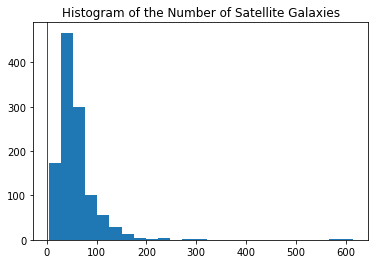

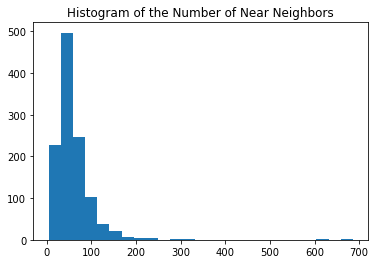

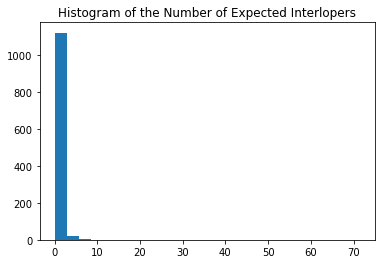

In [19]:
# Sum up satellite galaxies, expected interloper galaxies, and near neighbors
# Produce LaTeX code for a table with columns for projected radius, near neighbors, number of interlopers, number of
# satellite galaxies

sumsat = []
sumbkg = []
sumnear = []

# Sum up number of satellite galaxies for every LRG
for i in range(len(Nsat)):
    sumsat.append(np.sum(Nsat[i]))

# Sum up number of background galaxies for every LRG
for i in range(len(Nbkg)):
    sumbkg.append(np.sum(Nbkg[i]))
    
# Sum up number of near neighbors for every LRG
for i in range(len(near)):
    sumnear.append(np.sum(near[i]))

meannear = np.mean(sumnear)
print("mean near neighbor is", meannear)

sdnear = np.std(sumnear)
print("standard deviation of near neighbor is", sdnear)

meanbkg = np.mean(sumbkg)
print("mean interloper is", meanbkg)

sdbkg = np.std(sumbkg)
print("standard deviation of interloper is", sdbkg)

meansat = np.mean(sumsat)
print("mean number of satellites is", meansat)

medsat = np.median(sumsat)
print("median number of satellites is", medsat)

sdsat = np.std(sumsat)
print("standard deviation of satellites is", sdsat)

plt.title("Histogram of the Number of Satellite Galaxies")
plt.hist(sumsat, bins=25)
plt.axvline(linewidth=1, color='r')
plt.show()

plt.title("Histogram of the Number of Near Neighbors")
plt.hist(sumnear, bins=25)
plt.show()

plt.title("Histogram of the Number of Expected Interlopers")
plt.hist(sumbkg, bins=25)
plt.show()


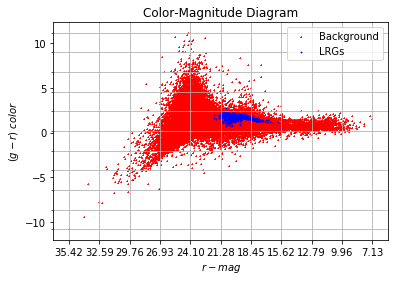

In [38]:
# CMD

fig, ax = plt.subplots()
ax.set_xticks(xedges, minor=False)
ax.set_yticks(yedges, minor=True)
ax.xaxis.grid(True, which='major')
ax.yaxis.grid(True, which='minor')

plt.scatter(rmag_BKG, color_BKG, s = 1, marker = '+', color='red', label="Background")
plt.scatter(rmag_LRG, color_LRG, s = 1, marker = '*', color='blue', label='LRGs')
plt.gca().invert_xaxis()
plt.title("Color-Magnitude Diagram")
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.legend(loc='upper right')
plt.show()

<class 'numpy.ndarray'>
(1151,)
mean number of satellites at z < 0.2: -2628222958.0
mean number of satellites at 0.2 <= z < 0.3: -1170037247.41
mean number of satellites at 0.3 <= z < 0.4: -809577412.659
mean number of satellites at 0.4 <= z < 0.5: -536497350.434
mean number of satellites at 0.5 <= z < 0.6: -441130803.764
mean number of satellites at 0.6 <= z < 0.7: -395140272.545
mean number of satellites at z < 0.7: -331529412.976
total number of Nsat arrays: 1151


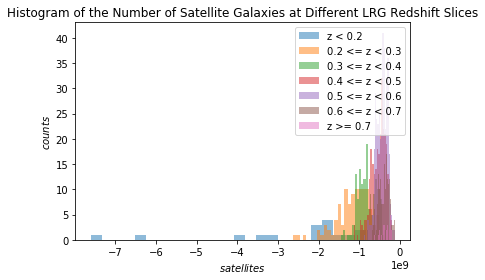

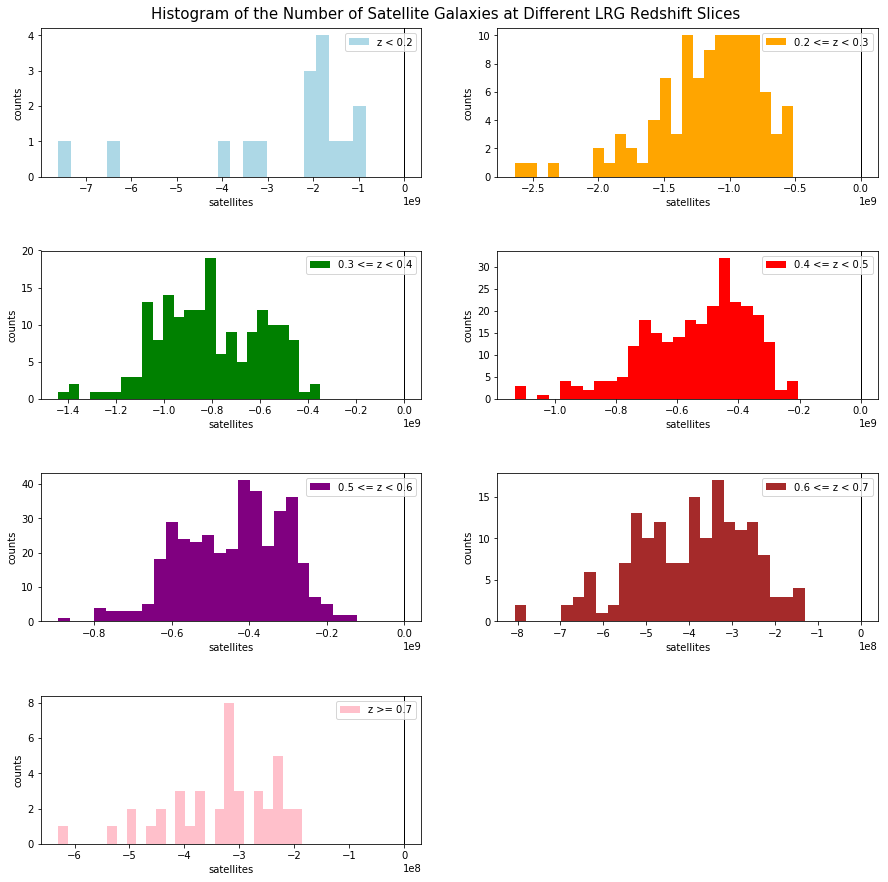

In [39]:
# Plot distribution of Nsat in different LRG redshift bins

# z_lrg = np.array(z_lrg)
# print("z = ", z_lrg)
# z_lrg = np.concatenate(z_lrg)
print(type(z_LRG))
print(z_LRG.shape)

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
Nsat1z = Nsat[np.where(z_LRG < 0.2)]
# print(len(Nsat1z))

sumsat1z = []
for i in range(len(Nsat1z)):
    sumsat1z.append(np.sum(Nsat1z[i]))
    
# 0.2 <= z < 0.3
Nsat2z = Nsat[np.where((z_LRG >= 0.2) & (0.3 > z_LRG))]
# print(len(Nsat2z))

sumsat2z = []
for i in range(len(Nsat2z)):
    sumsat2z.append(np.sum(Nsat2z[i]))

# 0.3 <= z < 0.4
Nsat3z = Nsat[np.where((z_LRG >= 0.3) & (0.4 > z_LRG))]
# print(len(Nsat3z))

sumsat3z = []
for i in range(len(Nsat3z)):
    sumsat3z.append(np.sum(Nsat3z[i]))
    
# 0.4 <= z < 0.5
Nsat4z = Nsat[np.where((z_LRG >= 0.4) & (0.5 > z_LRG))]
# print(len(Nsat4z))

sumsat4z = []
for i in range(len(Nsat4z)):
    sumsat4z.append(np.sum(Nsat4z[i]))
    
# 0.5 <= z < 0.6
Nsat5z = Nsat[np.where((z_LRG >= 0.5) & (0.6 > z_LRG))]
# print(len(Nsat5z))

sumsat5z = []
for i in range(len(Nsat5z)):
    sumsat5z.append(np.sum(Nsat5z[i]))
    
# 0.6 <= z < 0.7
Nsat6z = Nsat[np.where((z_LRG >= 0.6) & (0.7 > z_LRG))]
# print(len(Nsat6z))

sumsat6z = []
for i in range(len(Nsat6z)):
    sumsat6z.append(np.sum(Nsat6z[i]))
    
# z >= 0.7
Nsat7z = Nsat[np.where(z_LRG >= 0.7)]
# print(len(Nsat7z))

sumsat7z = []
for i in range(len(Nsat7z)):
    sumsat7z.append(np.sum(Nsat7z[i]))
    
# Calculate mean for every redshift slice
mean_sumsat1z = np.mean(sumsat1z)
print("mean number of satellites at z < 0.2:", mean_sumsat1z)
mean_sumsat2z = np.mean(sumsat2z)
print("mean number of satellites at 0.2 <= z < 0.3:", mean_sumsat2z)
mean_sumsat3z = np.mean(sumsat3z)
print("mean number of satellites at 0.3 <= z < 0.4:", mean_sumsat3z)
mean_sumsat4z = np.mean(sumsat4z)
print("mean number of satellites at 0.4 <= z < 0.5:", mean_sumsat4z)
mean_sumsat5z = np.mean(sumsat5z)
print("mean number of satellites at 0.5 <= z < 0.6:", mean_sumsat5z)
mean_sumsat6z = np.mean(sumsat6z)
print("mean number of satellites at 0.6 <= z < 0.7:", mean_sumsat6z)
mean_sumsat7z = np.mean(sumsat7z)
print("mean number of satellites at z < 0.7:", mean_sumsat7z)

print('total number of Nsat arrays:', len(Nsat1z) + len(Nsat2z) + len(Nsat3z) + len(Nsat4z) + len(Nsat5z) + len(Nsat6z) + len(Nsat7z))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG Redshift Slices")
plt.hist(sumsat1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumsat2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumsat3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumsat4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumsat5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumsat6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumsat7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$satellites$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Satellite Galaxies at Different LRG Redshift Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumsat1z, bins=25, color='lightblue', label='z < 0.2')
axarr[0, 0].legend(loc='upper right')
axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumsat2z, bins=25, color='orange',label='0.2 <= z < 0.3')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumsat3z, bins=25, color='green', label='0.3 <= z < 0.4')
axarr[1, 0].legend(loc='upper right')
axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumsat4z, bins=25, color='red', label='0.4 <= z < 0.5')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumsat5z, bins=25, color='purple', label='0.5 <= z < 0.6')
axarr[2,0].legend(loc='upper right')
axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumsat6z, bins=25, color='brown', label='0.6 <= z < 0.7')
axarr[2,1].legend(loc='upper right')
axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumsat7z, bins=25, color='pink', label='z >= 0.7')
axarr[3,0].legend(loc='upper right')
axarr[3,0].axvline(linewidth=1, color='black')

# axarr[3, 1].scatter(x, y ** 2)
# axarr[3, 1].set_title('Axis [3,1]')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='satellites', ylabel='counts')

plt.show()

    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG z < 0.2")
# plt.hist(sumsat1z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.2 <= z < 0.3")
# plt.hist(sumsat2z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.3 <= z < 0.4")
# plt.hist(sumsat3z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.4 <= z < 0.5")
# plt.hist(sumsat4z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.5 <= z < 0.6")
# plt.hist(sumsat5z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 0.6 <= z < 0.7")
# plt.hist(sumsat6z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG z >= 0.7")
# plt.hist(sumsat7z, bins=25)
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()


mean number of near neighbors at z < 0.2: 242.0
mean number of near neighbors at 0.2 <= z < 0.3: 111.08490566
mean number of near neighbors at 0.3 <= z < 0.4: 76.3583815029
mean number of near neighbors at 0.4 <= z < 0.5: 51.8127340824
mean number of near neighbors at 0.5 <= z < 0.6: 43.4803149606
mean number of near neighbors at 0.6 <= z < 0.7: 38.8323353293
mean number of near neighbors at z < 0.7: 30.9268292683
total number of sumnear arrays: 1151


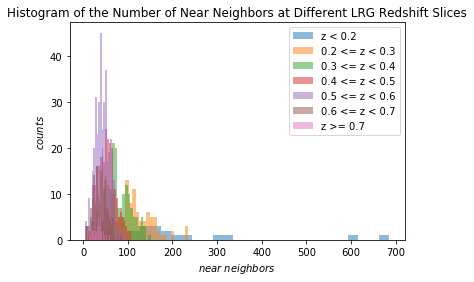

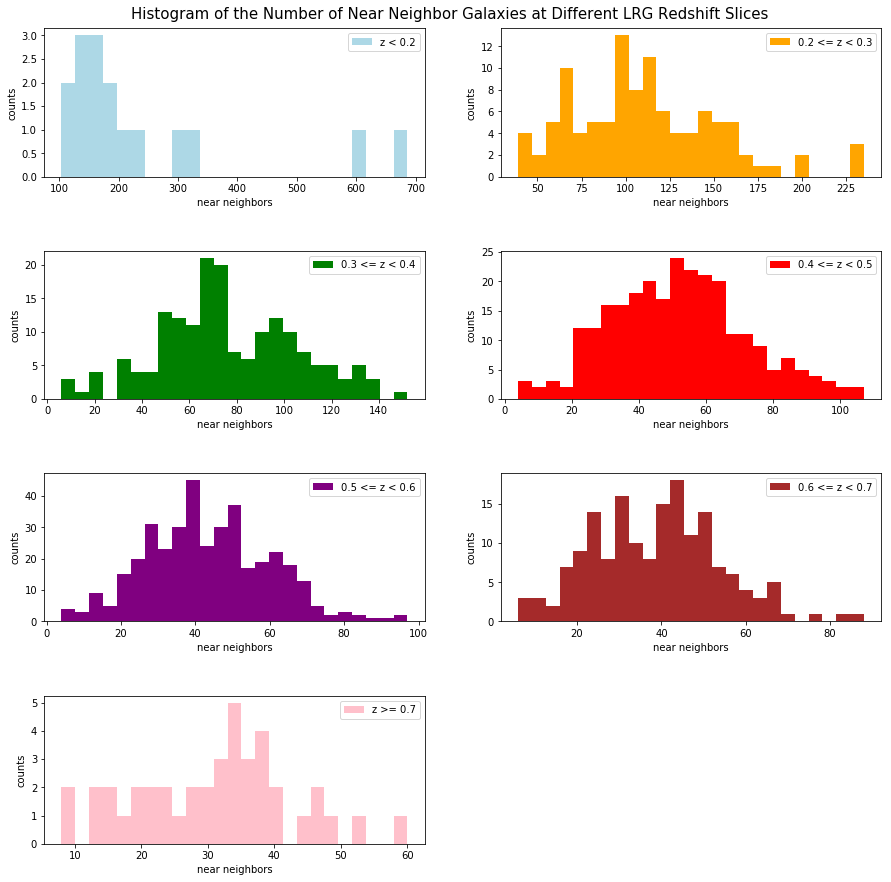

In [24]:
# Plot distribution of nn in different LRG redshift bins

near = np.array(near)
# print("z = ", z)
# print(type(z))

# LRG redshift from 0.0721669 <= z <= 0.846769
# bins of ~0.1

# z < 0.2
near1z = near[np.where(z_LRG < 0.2)]
# print(len(Nsat1))

sumnear1z = []
for i in range(len(near1z)):
    sumnear1z.append(np.sum(near1z[i]))

# 0.2 <= z < 0.3
near2z = near[np.where((z_LRG >= 0.2) & (0.3 > z_LRG))]
# print(len(Nsat2))

sumnear2z = []
for i in range(len(near2z)):
    sumnear2z.append(np.sum(near2z[i]))

# 0.3 <= z < 0.4
near3z = near[np.where((z_LRG >= 0.3) & (0.4 > z_LRG))]
# print(len(Nsat3))

sumnear3z = []
for i in range(len(near3z)):
    sumnear3z.append(np.sum(near3z[i]))

# 0.4 <= z < 0.5
near4z = near[np.where((z_LRG >= 0.4) & (0.5 > z_LRG))]
# print(len(Nsat4))

sumnear4z = []
for i in range(len(near4z)):
    sumnear4z.append(np.sum(near4z[i]))

# 0.5 <= z < 0.6
near5z = near[np.where((z_LRG >= 0.5) & (0.6 > z_LRG))]
# print(len(Nsat5))

sumnear5z = []
for i in range(len(near5z)):
    sumnear5z.append(np.sum(near5z[i]))

# 0.6 <= z < 0.7
near6z = near[np.where((z_LRG >= 0.6) & (0.7 > z_LRG))]
# print(len(Nsat6))

sumnear6z = []
for i in range(len(near6z)):
    sumnear6z.append(np.sum(near6z[i]))

# z >= 0.7
near7z = near[np.where(z_LRG >= 0.7)]
# print(len(Nsat7))

sumnear7z = []
for i in range(len(near7z)):
    sumnear7z.append(np.sum(near7z[i]))
    
# Calculate mean for every redshift slice
mean_sumnear1z = np.mean(sumnear1z)
print("mean number of near neighbors at z < 0.2:", mean_sumnear1z)
mean_sumnear2z = np.mean(sumnear2z)
print("mean number of near neighbors at 0.2 <= z < 0.3:", mean_sumnear2z)
mean_sumnear3z = np.mean(sumnear3z)
print("mean number of near neighbors at 0.3 <= z < 0.4:", mean_sumnear3z)
mean_sumnear4z = np.mean(sumnear4z)
print("mean number of near neighbors at 0.4 <= z < 0.5:", mean_sumnear4z)
mean_sumnear5z = np.mean(sumnear5z)
print("mean number of near neighbors at 0.5 <= z < 0.6:", mean_sumnear5z)
mean_sumnear6z = np.mean(sumnear6z)
print("mean number of near neighbors at 0.6 <= z < 0.7:", mean_sumnear6z)
mean_sumnear7z = np.mean(sumnear7z)
print("mean number of near neighbors at z < 0.7:", mean_sumnear7z)
    
print('total number of sumnear arrays:', len(near1z) + len(near2z) + len(near3z) + len(near4z) + len(near5z) + len(near6z) + len(near7z))

plt.title("Histogram of the Number of Near Neighbors at Different LRG Redshift Slices")
plt.hist(sumnear1z, bins=25, alpha=0.5, label='z < 0.2')
plt.hist(sumnear2z, bins=25, alpha=0.5, label='0.2 <= z < 0.3')
plt.hist(sumnear3z, bins=25, alpha=0.5, label='0.3 <= z < 0.4')
plt.hist(sumnear4z, bins=25, alpha=0.5, label='0.4 <= z < 0.5')
plt.hist(sumnear5z, bins=25, alpha=0.5, label='0.5 <= z < 0.6')
plt.hist(sumnear6z, bins=25, alpha=0.5, label='0.6 <= z < 0.7')
plt.hist(sumnear7z, bins=25, alpha=0.5, label='z >= 0.7')
plt.xlabel(r'$near$ $neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Near Neighbor Galaxies at Different LRG Redshift Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumnear1z, bins=25, color='lightblue', label='z < 0.2')
axarr[0, 0].legend(loc='upper right')
# axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumnear2z, bins=25, color='orange',label='0.2 <= z < 0.3')
axarr[0, 1].legend(loc='upper right')
# axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumnear3z, bins=25, color='green', label='0.3 <= z < 0.4')
axarr[1, 0].legend(loc='upper right')
# axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumnear4z, bins=25, color='red', label='0.4 <= z < 0.5')
axarr[1, 1].legend(loc='upper right')
# axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumnear5z, bins=25, color='purple', label='0.5 <= z < 0.6')
axarr[2,0].legend(loc='upper right')
# axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumnear6z, bins=25, color='brown', label='0.6 <= z < 0.7')
axarr[2,1].legend(loc='upper right')
# axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumnear7z, bins=25, color='pink', label='z >= 0.7')
axarr[3,0].legend(loc='upper right')
# axarr[3,0].axvline(linewidth=1, color='black')

# axarr[3, 1].scatter(x, y ** 2)
# axarr[3, 1].set_title('Axis [3,1]')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='near neighbors', ylabel='counts')

plt.show()

    
# plt.title("Histogram of the Number of Near Neighbors at LRG z < 0.2")
# plt.hist(sumnear1z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.2 <= z < 0.3")
# plt.hist(sumnear2z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.3 <= z < 0.4")
# plt.hist(sumnear3z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.4 <= z < 0.5")
# plt.hist(sumnear4z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.5 <= z < 0.6")
# plt.hist(sumnear5z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 0.6 <= z < 0.7")
# plt.hist(sumnear6z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG z >= 0.7")
# plt.hist(sumnear7z, bins=25)
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

mean number of satellites at 15 <= rmag < 16: 1.61912679504
mean number of satellites at 16 <= rmag < 17: 123.06072278
mean number of satellites at 17 <= rmag < 18: 13.9840482351
mean number of satellites at 18 <= rmag < 19: 17.4909015977
mean number of satellites at 19 <= rmag < 20: 13.0599503707
mean number of satellites at 20 <= rmag < 21: 8.84639957084
mean number of satellites at rmag >= 21: 8.49604799967
total number of Nsat arrays: 1151


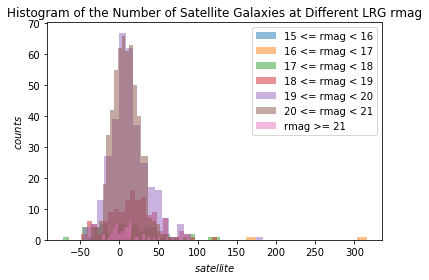

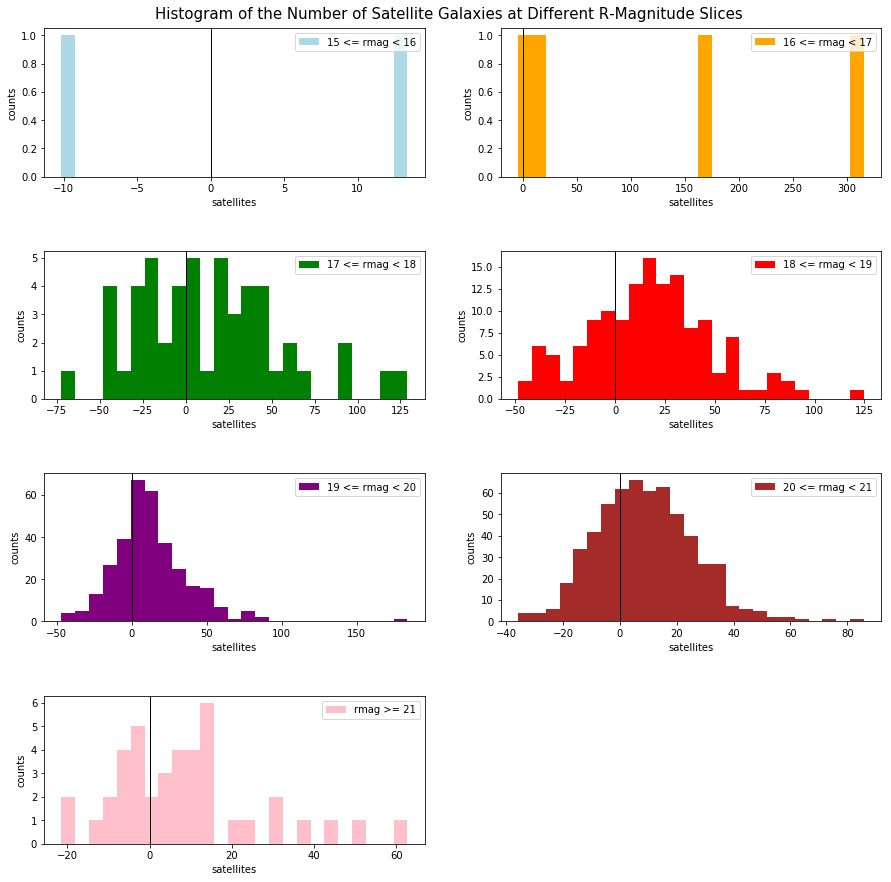

In [12]:
# Plot distribution of Nsat in different LRG rmag bins

rmag_LRG = np.array(rmag_LRG)
# print("z = ", z)
# print(type(z))

# LRG rmag from 22.3639 <= rmag <= 15.8399
# bins of ~1 mag

# 15 <= rmag < 16
Nsat1r = Nsat[np.where((rmag_LRG >= 15.) & (16. > rmag_LRG))]
# print(len(Nsat1))

sumsat1r = []
for i in range(len(Nsat1r)):
    sumsat1r.append(np.sum(Nsat1r[i]))

# 16 <= rmag < 17
Nsat2r = Nsat[np.where((rmag_LRG >= 16.) & (17. > rmag_LRG))]
# print(len(Nsat2))

sumsat2r = []
for i in range(len(Nsat2r)):
    sumsat2r.append(np.sum(Nsat2r[i]))

# 17 <= rmag < 18
Nsat3r = Nsat[np.where((rmag_LRG >= 17.) & (18. > rmag_LRG))]
# print(len(Nsat3))

sumsat3r = []
for i in range(len(Nsat3r)):
    sumsat3r.append(np.sum(Nsat3r[i]))

# 18 <= rmag < 19
Nsat4r = Nsat[np.where((rmag_LRG >= 18.) & (19. > rmag_LRG))]
# print(len(Nsat4))

sumsat4r = []
for i in range(len(Nsat4r)):
    sumsat4r.append(np.sum(Nsat4r[i]))

# 19 <= rmag < 20
Nsat5r = Nsat[np.where((rmag_LRG >= 19.) & (20. > rmag_LRG))]
# print(len(Nsat5))

sumsat5r = []
for i in range(len(Nsat5r)):
    sumsat5r.append(np.sum(Nsat5r[i]))

# 20 <= rmag < 21
Nsat6r = Nsat[np.where((rmag_LRG >= 20.) & (21. > rmag_LRG))]
# print(len(Nsat6))

sumsat6r = []
for i in range(len(Nsat6r)):
    sumsat6r.append(np.sum(Nsat6r[i]))

# rmag >= 21
Nsat7r = Nsat[np.where(rmag_LRG >= 21.)]
# print(len(Nsat7))

sumsat7r = []
for i in range(len(Nsat7r)):
    sumsat7r.append(np.sum(Nsat7r[i]))
    
# Calculate mean for every rmag slice
mean_sumsat1r = np.mean(sumsat1r)
print("mean number of satellites at 15 <= rmag < 16:", mean_sumsat1r)
mean_sumsat2r = np.mean(sumsat2r)
print("mean number of satellites at 16 <= rmag < 17:", mean_sumsat2r)
mean_sumsat3r = np.mean(sumsat3r)
print("mean number of satellites at 17 <= rmag < 18:", mean_sumsat3r)
mean_sumsat4r = np.mean(sumsat4r)
print("mean number of satellites at 18 <= rmag < 19:", mean_sumsat4r)
mean_sumsat5r = np.mean(sumsat5r)
print("mean number of satellites at 19 <= rmag < 20:", mean_sumsat5r)
mean_sumsat6r = np.mean(sumsat6r)
print("mean number of satellites at 20 <= rmag < 21:", mean_sumsat6r)
mean_sumsat7r = np.mean(sumsat7r)
print("mean number of satellites at rmag >= 21:", mean_sumsat7r)
    
print('total number of Nsat arrays:', len(Nsat1r) + len(Nsat2r) + len(Nsat3r) + len(Nsat4r) + len(Nsat5r) + len(Nsat6r) + len(Nsat7r))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG rmag")
plt.hist(sumsat1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumsat2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumsat3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumsat4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumsat5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumsat6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumsat7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Satellite Galaxies at Different R-Magnitude Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumsat1r, bins=25, color='lightblue', label='15 <= rmag < 16')
axarr[0, 0].legend(loc='upper right')
axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumsat2r, bins=25, color='orange', label='16 <= rmag < 17')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumsat3r, bins=25, color='green', label='17 <= rmag < 18')
axarr[1, 0].legend(loc='upper right')
axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumsat4r, bins=25, color='red', label='18 <= rmag < 19')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumsat5r, bins=25, color='purple', label='19 <= rmag < 20')
axarr[2,0].legend(loc='upper right')
axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumsat6r, bins=25, color='brown', label='20 <= rmag < 21')
axarr[2,1].legend(loc='upper right')
axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumsat7r, bins=25, color='pink', label='rmag >= 21')
axarr[3,0].legend(loc='upper right')
axarr[3,0].axvline(linewidth=1, color='black')

# axarr[3,1].hist(sumsat7z, bins=25, color='pink', label='z >= 0.7')
# axarr[3,1].legend(loc='upper right')
# axarr[3,1].axvline(linewidth=1, color='black')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='satellites', ylabel='counts')

plt.show()
    
# plt.title("Histogram of the Number of Satellite Galaxies at LRG 15 <= rmag < 16")
# plt.hist(sumsat1r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 16 <= rmag < 17")
# plt.hist(sumsat2r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  17 <= rmag < 18")
# plt.hist(sumsat3r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= rmag < 19")
# plt.hist(sumsat4r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 19 <= rmag < 20")
# plt.hist(sumsat5r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= rmag < 21")
# plt.hist(sumsat6r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG rmag >= 21")
# plt.hist(sumsat7r, bins=25, color='red')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

1151
1
3
13
86
145
401
461
mean number of satellites at 16 <= gmag < 17: -10.1416536734
mean number of satellites at 17 <= gmag < 18: 5.80538138487
mean number of satellites at 18 <= gmag < 19: 54.4024009413
mean number of satellites at 19 <= gmag < 20: 15.9506089943
mean number of satellites at 20 <= gmag < 21: 17.5081594854
mean number of satellites at 21 <= gmag < 22: 10.7533612084
mean number of satellites at 22 <= gmag < 23: 9.07665112626
mean number of satellites at gmag >= 23: 8.58069642817
total number of Nsat arrays: 1151


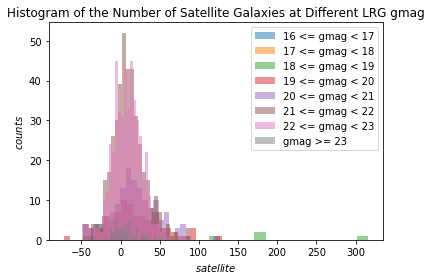

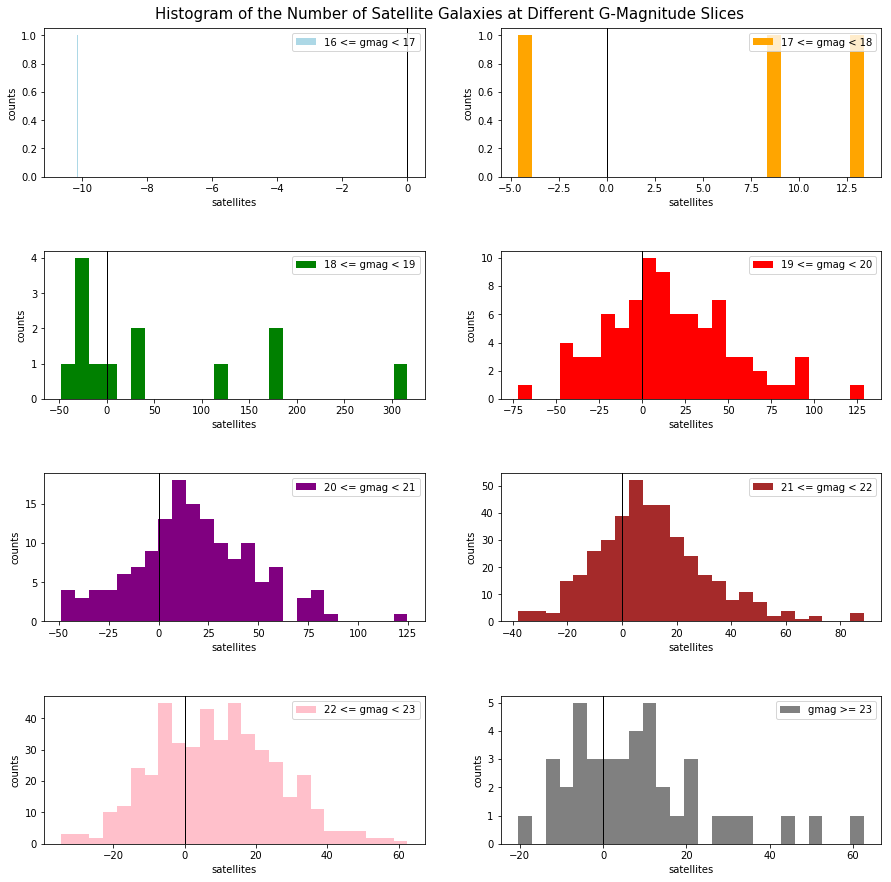

0


In [13]:
# Plot distribution of Nsat in different LRG gmag bins

gmag_LRG = np.array(gmag_LRG)
print(len(gmag_LRG))

# bins of ~1 mag

# 16 <= gmag < 17
Nsat1g = Nsat[np.where((gmag_LRG >= 16.) & (17. > gmag_LRG))]
print(len(Nsat1g))

sumsat1g = []
for i in range(len(Nsat1g)):
    sumsat1g.append(np.sum(Nsat1g[i]))

# 17 <= gmag < 18
Nsat2g = Nsat[np.where((gmag_LRG >= 17.) & (18. > gmag_LRG))]
print(len(Nsat2g))

sumsat2g = []
for i in range(len(Nsat2g)):
    sumsat2g.append(np.sum(Nsat2g[i]))

# 18 <= gmag < 19
Nsat3g = Nsat[np.where((gmag_LRG >= 18.) & (19. > gmag_LRG))]
print(len(Nsat3g))

sumsat3g = []
for i in range(len(Nsat3g)):
    sumsat3g.append(np.sum(Nsat3g[i]))

# 19 <= gmag < 20
Nsat4g = Nsat[np.where((gmag_LRG >= 19.) & (20. > gmag_LRG))]
print(len(Nsat4g))

sumsat4g = []
for i in range(len(Nsat4g)):
    sumsat4g.append(np.sum(Nsat4g[i]))

# 20 <= gmag < 21
Nsat5g = Nsat[np.where((gmag_LRG >= 20.) & (21. > gmag_LRG))]
print(len(Nsat5g))

sumsat5g = []
for i in range(len(Nsat5g)):
    sumsat5g.append(np.sum(Nsat5g[i]))

# 21 <= gmag < 22
Nsat6g = Nsat[np.where((gmag_LRG >= 21.) & (22. > gmag_LRG))]
print(len(Nsat6g))

sumsat6g = []
for i in range(len(Nsat6g)):
    sumsat6g.append(np.sum(Nsat6g[i]))
    
# 22 <= gmag < 23
Nsat7g = Nsat[np.where((gmag_LRG >= 22.) & (23. > gmag_LRG))]
print(len(Nsat7g))

sumsat7g = []
for i in range(len(Nsat7g)):
    sumsat7g.append(np.sum(Nsat7g[i]))

# gmag >= 23
Nsat8g = Nsat[np.where(gmag_LRG >= 23.)]
# print(len(Nsat8))

sumsat8g = []
for i in range(len(Nsat8g)):
    sumsat8g.append(np.sum(Nsat8g[i]))  

# Calculate mean for every gmag slice
mean_sumsat1g = np.mean(sumsat1g)
print("mean number of satellites at 16 <= gmag < 17:", mean_sumsat1g)
mean_sumsat2g = np.mean(sumsat2g)
print("mean number of satellites at 17 <= gmag < 18:", mean_sumsat2g)
mean_sumsat3g = np.mean(sumsat3g)
print("mean number of satellites at 18 <= gmag < 19:", mean_sumsat3g)
mean_sumsat4g = np.mean(sumsat4g)
print("mean number of satellites at 19 <= gmag < 20:", mean_sumsat4g)
mean_sumsat5g = np.mean(sumsat5g)
print("mean number of satellites at 20 <= gmag < 21:", mean_sumsat5g)
mean_sumsat6g = np.mean(sumsat6g)
print("mean number of satellites at 21 <= gmag < 22:", mean_sumsat6g)
mean_sumsat7g = np.mean(sumsat7g)
print("mean number of satellites at 22 <= gmag < 23:", mean_sumsat7g)
mean_sumsat8g = np.mean(sumsat8g)
print("mean number of satellites at gmag >= 23:", mean_sumsat8g)

print('total number of Nsat arrays:', len(Nsat1g) + len(Nsat2g) + len(Nsat3g) + len(Nsat4g) + len(Nsat5g) + len(Nsat6g) + len(Nsat7g) + len(Nsat8g))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG gmag")               # alsdkfjalsdfjka;sldfkjlsdfjlsdjkflsdkjflsdkjf;lsdkjflsdkjfl
plt.hist(sumsat1g, bins=25, alpha=0.5, label='16 <= gmag < 17')
plt.hist(sumsat2g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumsat3g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumsat4g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumsat5g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumsat6g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumsat7g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumsat8g, bins=25, alpha=0.5, label='gmag >= 23')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Satellite Galaxies at Different G-Magnitude Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumsat1g, bins=25, color='lightblue', label='16 <= gmag < 17')
axarr[0, 0].legend(loc='upper right')
axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumsat2g, bins=25, color='orange', label='17 <= gmag < 18')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumsat3g, bins=25, color='green', label='18 <= gmag < 19')
axarr[1, 0].legend(loc='upper right')
axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumsat4g, bins=25, color='red', label='19 <= gmag < 20')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumsat5g, bins=25, color='purple', label='20 <= gmag < 21')
axarr[2,0].legend(loc='upper right')
axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumsat6g, bins=25, color='brown', label='21 <= gmag < 22')
axarr[2,1].legend(loc='upper right')
axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumsat7g, bins=25, color='pink', label='22 <= gmag < 23')
axarr[3,0].legend(loc='upper right')
axarr[3,0].axvline(linewidth=1, color='black')

axarr[3,1].hist(sumsat8g, bins=25, color='grey', label='gmag >= 23')
axarr[3,1].legend(loc='upper right')
axarr[3,1].axvline(linewidth=1, color='black')

# f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='satellites', ylabel='counts')

plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 17 <= gmag < 18")
# plt.hist(sumsat1g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 18 <= gmag < 19")
# plt.hist(sumsat2g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG  19 <= gmag < 20")
# plt.hist(sumsat3g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 20 <= gmag < 21")
# plt.hist(sumsat4g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 21 <= gmag < 22")
# plt.hist(sumsat5g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 22 <= gmag < 23")
# plt.hist(sumsat6g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG 23 <= gmag < 24")
# plt.hist(sumsat7g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Satellite Galaxies at LRG gmag >= 24")
# plt.hist(sumsat8g, bins=25, color='g')
# plt.xlabel(r'$satellites$')
# plt.ylabel(r'$counts$')
# plt.show()

print(len(gmag_LRG[np.where(gmag_LRG >= 24.)]))

1151
mean number of satellites at 14 <= zmag < 15: 1.61912679504
mean number of satellites at 15 <= zmag < 16: 58.7248574258
mean number of satellites at 16 <= zmag < 17: 13.5075915089
mean number of satellites at 17 <= zmag < 18: 17.8416491731
mean number of satellites at 18 <= zmag < 19: 12.6075497022
mean number of satellites at 19 <= zmag < 20: 8.2291103824
mean number of satellites at zmag >= 20: 18.7726889978
total number of Nsat arrays: 1151


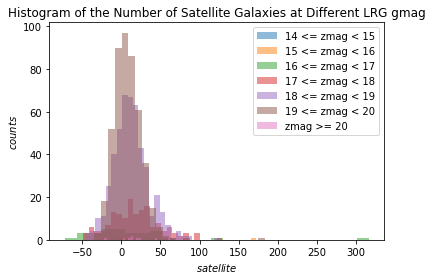

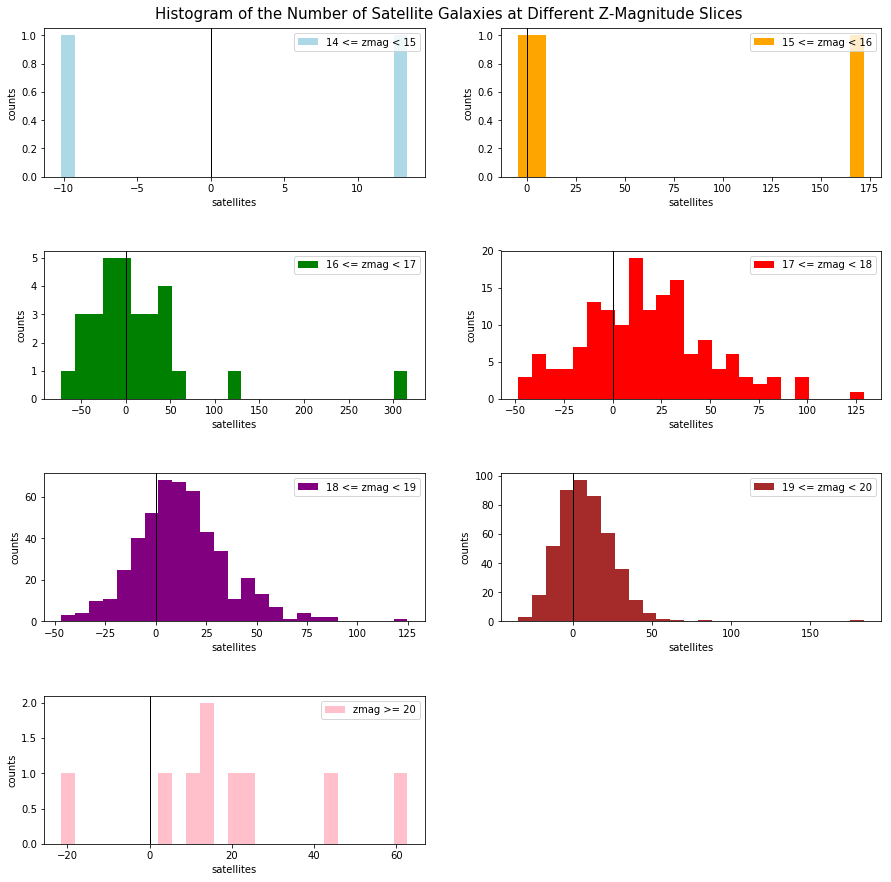

In [14]:
# Plot distribution of Nsat in different LRG zmag bins

zmag_LRG = np.array(zmag_LRG)
print(len(zmag_LRG))

# LRG gmag from 25.1832 <= rmag <= 17.0737
# bins of ~1 mag

# 14 <= zmag < 15
Nsat1z = Nsat[np.where((zmag_LRG >= 14.) & (15. > zmag_LRG))]
# print(len(Nsat1g))

sumsat1z = []
for i in range(len(Nsat1z)):
    sumsat1z.append(np.sum(Nsat1z[i]))

# 15 <= zmag < 16
Nsat2z = Nsat[np.where((zmag_LRG >= 15.) & (16. > zmag_LRG))]
# print(len(Nsat2g))

sumsat2z = []
for i in range(len(Nsat2z)):
    sumsat2z.append(np.sum(Nsat2z[i]))

# 16 <= zmag < 17
Nsat3z = Nsat[np.where((zmag_LRG >= 16.) & (17. > zmag_LRG))]
# print(len(Nsat3g))

sumsat3z = []
for i in range(len(Nsat3z)):
    sumsat3z.append(np.sum(Nsat3z[i]))

# 17 <= zmag < 18
Nsat4z = Nsat[np.where((zmag_LRG >= 17.) & (18. > zmag_LRG))]
# print(len(Nsat4z))

sumsat4z = []
for i in range(len(Nsat4z)):
    sumsat4z.append(np.sum(Nsat4z[i]))

# 18 <= zmag < 19
Nsat5z = Nsat[np.where((zmag_LRG >= 18.) & (19. > zmag_LRG))]
# print(len(Nsat5g))

sumsat5z = []
for i in range(len(Nsat5z)):
    sumsat5z.append(np.sum(Nsat5z[i]))

# 19 <= zmag < 20
Nsat6z = Nsat[np.where((zmag_LRG >= 19.) & (20. > zmag_LRG))]
# print(len(Nsat6g))

sumsat6z = []
for i in range(len(Nsat6z)):
    sumsat6z.append(np.sum(Nsat6z[i]))

# zmag < 20
Nsat7z = Nsat[np.where(zmag_LRG >= 20.)]
# print(len(Nsat8))

sumsat7z = []
for i in range(len(Nsat7z)):
    sumsat7z.append(np.sum(Nsat7z[i]))

# Calculate mean for every zmag slice
mean_sumsat1z = np.mean(sumsat1z)
print("mean number of satellites at 14 <= zmag < 15:", mean_sumsat1z)
mean_sumsat2z = np.mean(sumsat2z)
print("mean number of satellites at 15 <= zmag < 16:", mean_sumsat2z)
mean_sumsat3z = np.mean(sumsat3z)
print("mean number of satellites at 16 <= zmag < 17:", mean_sumsat3z)
mean_sumsat4z = np.mean(sumsat4z)
print("mean number of satellites at 17 <= zmag < 18:", mean_sumsat4z)
mean_sumsat5z = np.mean(sumsat5z)
print("mean number of satellites at 18 <= zmag < 19:", mean_sumsat5z)
mean_sumsat6z = np.mean(sumsat6z)
print("mean number of satellites at 19 <= zmag < 20:", mean_sumsat6z)
mean_sumsat7z = np.mean(sumsat7z)
print("mean number of satellites at zmag >= 20:", mean_sumsat7z)

print('total number of Nsat arrays:', len(Nsat1z) + len(Nsat2z) + len(Nsat3z) + len(Nsat4z) + len(Nsat5z) + len(Nsat6z) + len(Nsat7z))

plt.title("Histogram of the Number of Satellite Galaxies at Different LRG gmag")               # alsdkfjalsdfjka;sldfkjlsdfjlsdjkflsdkjflsdkjf;lsdkjflsdkjfl
plt.hist(sumsat1z, bins=25, alpha=0.5, label='14 <= zmag < 15')
plt.hist(sumsat2z, bins=25, alpha=0.5, label='15 <= zmag < 16')
plt.hist(sumsat3z, bins=25, alpha=0.5, label='16 <= zmag < 17')
plt.hist(sumsat4z, bins=25, alpha=0.5, label='17 <= zmag < 18')
plt.hist(sumsat5z, bins=25, alpha=0.5, label='18 <= zmag < 19')
plt.hist(sumsat6z, bins=25, alpha=0.5, label='19 <= zmag < 20')
plt.hist(sumsat7z, bins=25, alpha=0.5, label='zmag >= 20')
plt.xlabel(r'$satellite$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Satellite Galaxies at Different Z-Magnitude Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumsat1z, bins=25, color='lightblue', label='14 <= zmag < 15')
axarr[0, 0].legend(loc='upper right')
axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumsat2z, bins=25, color='orange', label='15 <= zmag < 16')
axarr[0, 1].legend(loc='upper right')
axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumsat3z, bins=25, color='green', label='16 <= zmag < 17')
axarr[1, 0].legend(loc='upper right')
axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumsat4z, bins=25, color='red', label='17 <= zmag < 18')
axarr[1, 1].legend(loc='upper right')
axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumsat5z, bins=25, color='purple', label='18 <= zmag < 19')
axarr[2,0].legend(loc='upper right')
axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumsat6z, bins=25, color='brown', label='19 <= zmag < 20')
axarr[2,1].legend(loc='upper right')
axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumsat7z, bins=25, color='pink', label='zmag >= 20')
axarr[3,0].legend(loc='upper right')
axarr[3,0].axvline(linewidth=1, color='black')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='satellites', ylabel='counts')

plt.show()


mean number of near neighbors at 15 <= rmag < 16: 137.0
mean number of near neighbors at 16 <= rmag < 17: 350.75
mean number of near neighbors at 17 <= rmag < 18: 122.921568627
mean number of near neighbors at 18 <= rmag < 19: 85.9078014184
mean number of near neighbors at 19 <= rmag < 20: 60.6890243902
mean number of near neighbors at 20 <= rmag < 21: 43.5154109589
mean number of near neighbors at rmag >= 21: 39.8048780488
total number of near arrays: 1151


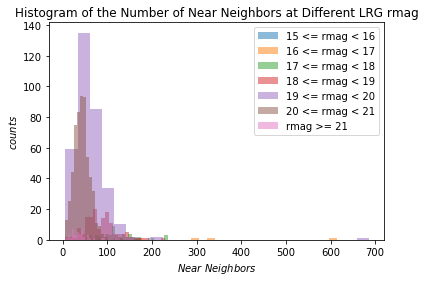

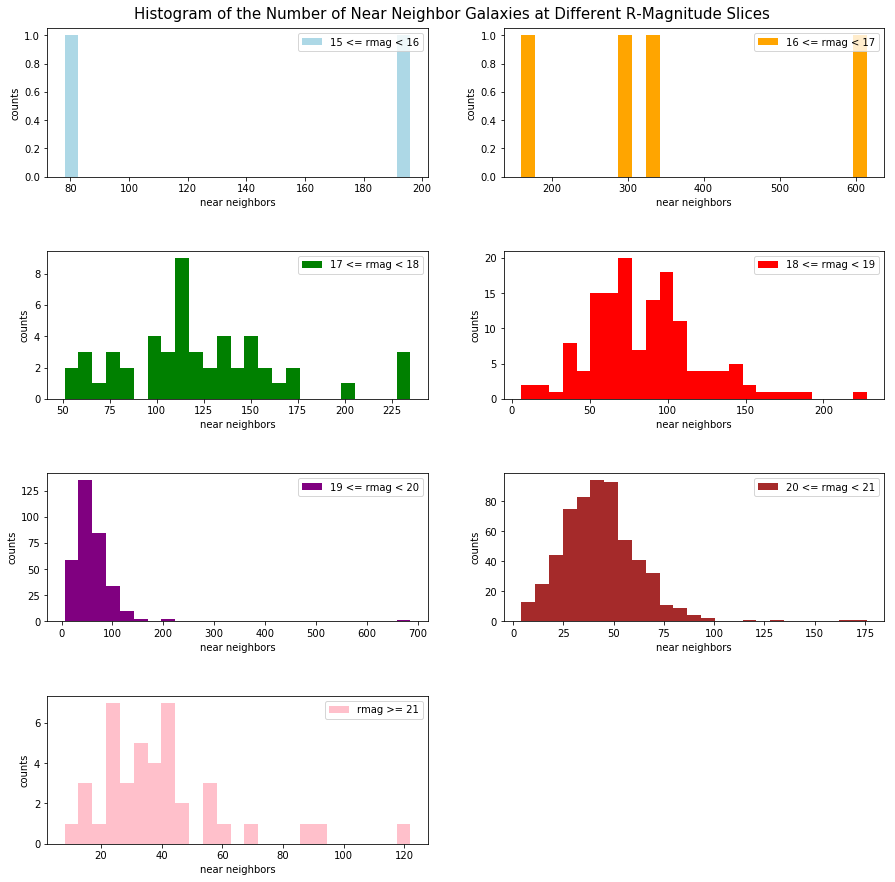

In [15]:
# Plot distribution of nn in different LRG rmag bins

rmag_LRG = np.array(rmag_LRG)
# print("z = ", z)
# print(type(z))

# bins of ~1 mag

# 15 <= rmag < 16
near1r = near[np.where((rmag_LRG >= 15.) & (16. > rmag_LRG))]
# print(len(Nsat1))

sumnear1r = []
for i in range(len(near1r)):
    sumnear1r.append(np.sum(near1r[i]))

# 16 <= rmag < 17
near2r = near[np.where((rmag_LRG >= 16.) & (17. > rmag_LRG))]
# print(len(Nsat2))

sumnear2r = []
for i in range(len(near2r)):
    sumnear2r.append(np.sum(near2r[i]))

# 17 <= rmag < 18
near3r = near[np.where((rmag_LRG >= 17.) & (18. > rmag_LRG))]
# print(len(Nsat3))

sumnear3r = []
for i in range(len(near3r)):
    sumnear3r.append(np.sum(near3r[i]))

# 18 <= rmag < 19
near4r = near[np.where((rmag_LRG >= 18.) & (19. > rmag_LRG))]
# print(len(Nsat4))

sumnear4r = []
for i in range(len(near4r)):
    sumnear4r.append(np.sum(near4r[i]))

# 19 <= rmag < 20
near5r = near[np.where((rmag_LRG >= 19.) & (20. > rmag_LRG))]
# print(len(Nsat5))

sumnear5r = []
for i in range(len(near5r)):
    sumnear5r.append(np.sum(near5r[i]))

# 20 <= rmag < 21
near6r = near[np.where((rmag_LRG >= 20.) & (21. > rmag_LRG))]
# print(len(Nsat6))

sumnear6r = []
for i in range(len(near6r)):
    sumnear6r.append(np.sum(near6r[i]))

# rmag >= 21
near7r = near[np.where(rmag_LRG >= 21.)]
# print(len(Nsat7))

sumnear7r = []
for i in range(len(near7r)):
    sumnear7r.append(np.sum(near7r[i]))
    
# Calculate mean for every rmag slice
mean_sumnear1r = np.mean(sumnear1r)
print("mean number of near neighbors at 15 <= rmag < 16:", mean_sumnear1r)
mean_sumnear2r = np.mean(sumnear2r)
print("mean number of near neighbors at 16 <= rmag < 17:", mean_sumnear2r)
mean_sumnear3r = np.mean(sumnear3r)
print("mean number of near neighbors at 17 <= rmag < 18:", mean_sumnear3r)
mean_sumnear4r = np.mean(sumnear4r)
print("mean number of near neighbors at 18 <= rmag < 19:", mean_sumnear4r)
mean_sumnear5r = np.mean(sumnear5r)
print("mean number of near neighbors at 19 <= rmag < 20:", mean_sumnear5r)
mean_sumnear6r = np.mean(sumnear6r)
print("mean number of near neighbors at 20 <= rmag < 21:", mean_sumnear6r)
mean_sumnear7r = np.mean(sumnear7r)
print("mean number of near neighbors at rmag >= 21:", mean_sumnear7r)
                                 
print('total number of near arrays:', len(near1r) + len(near2r) + len(near3r) + len(near4r) + len(near5r) + len(near6r) + len(near7r))
    
plt.title("Histogram of the Number of Near Neighbors at Different LRG rmag")
plt.hist(sumnear1r, bins=25, alpha=0.5, label='15 <= rmag < 16')
plt.hist(sumnear2r, bins=25, alpha=0.5, label='16 <= rmag < 17')
plt.hist(sumnear3r, bins=25, alpha=0.5, label='17 <= rmag < 18')
plt.hist(sumnear4r, bins=25, alpha=0.5, label='18 <= rmag < 19')
plt.hist(sumnear5r, bins=25, alpha=0.5, label='19 <= rmag < 20')
plt.hist(sumnear6r, bins=25, alpha=0.5, label='20 <= rmag < 21')
plt.hist(sumnear7r, bins=25, alpha=0.5, label='rmag >= 21')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()
    
    
f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Near Neighbor Galaxies at Different R-Magnitude Slices", fontsize=15, y=0.9)    # alsdjf'lasdjf'lasdfj'alsdfja;lsdfj;alsdfjdsf'

axarr[0, 0].hist(sumnear1r, bins=25, color='lightblue', label='15 <= rmag < 16')
axarr[0, 0].legend(loc='upper right')
# axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumnear2r, bins=25, color='orange', label='16 <= rmag < 17')
axarr[0, 1].legend(loc='upper right')
# axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumnear3r, bins=25, color='green', label='17 <= rmag < 18')
axarr[1, 0].legend(loc='upper right')
# axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumnear4r, bins=25, color='red', label='18 <= rmag < 19')
axarr[1, 1].legend(loc='upper right')
# axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumnear5r, bins=25, color='purple', label='19 <= rmag < 20')
axarr[2,0].legend(loc='upper right')
# axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumnear6r, bins=25, color='brown', label='20 <= rmag < 21')
axarr[2,1].legend(loc='upper right')
# axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumnear7r, bins=25, color='pink', label='rmag >= 21')
axarr[3,0].legend(loc='upper right')
# axarr[3,0].axvline(linewidth=1, color='black')

# axarr[3,1].hist(sumsat7z, bins=25, color='pink', label='z >= 0.7')
# axarr[3,1].legend(loc='upper right')
# axarr[3,1].axvline(linewidth=1, color='black')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='near neighbors', ylabel='counts')

plt.show()

    
# plt.title("Histogram of the Number of Near Neighbors at LRG 15 <= rmag < 16")
# plt.hist(sumnear1r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 16 <= rmag < 17")
# plt.hist(sumnear2r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  17 <= rmag < 18")
# plt.hist(sumnear3r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= rmag < 19")
# plt.hist(sumnear4r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 19 <= rmag < 20")
# plt.hist(sumnear5r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= rmag < 21")
# plt.hist(sumnear6r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG rmag >= 21")
# plt.hist(sumnear7r, bins=25, color='red')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()


mean number of near neighbors at 16 <= gmag < 17: 78.0
mean number of near neighbors at 17 <= gmag < 18: 227.0
mean number of near neighbors at 18 <= gmag < 19: 213.692307692
mean number of near neighbors at 19 <= gmag < 20: 110.860465116
mean number of near neighbors at 20 <= gmag < 21: 79.9310344828
mean number of near neighbors at 21 <= gmag < 22: 52.1496259352
mean number of near neighbors at 22 <= gmag < 23: 42.9848156182
mean number of near neighbors at gmag >= 23: 39.5365853659
total number of near arrays: 1151


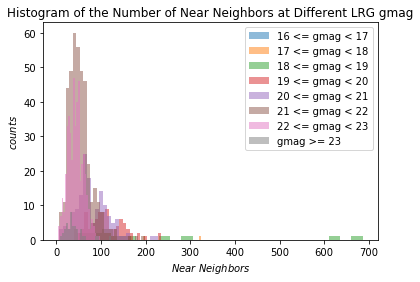

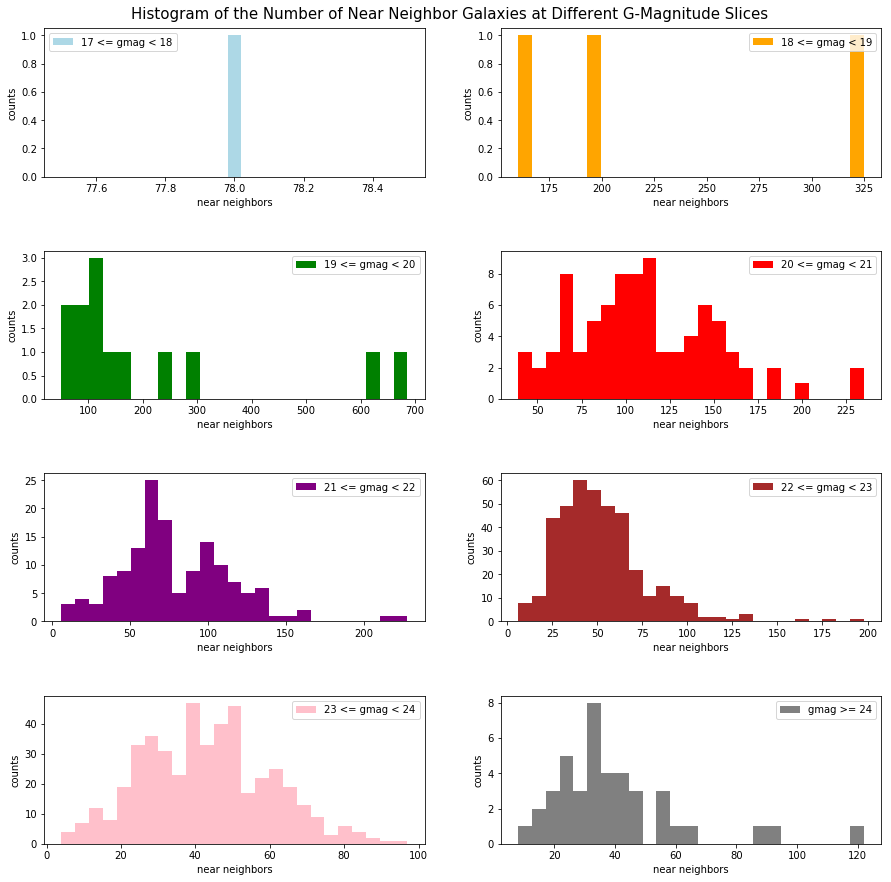

In [16]:
# Plot distribution of nn in different LRG gmag bins

gmag_LRG = np.array(gmag_LRG)
# print("z = ", z)
# print(type(z))

# bins of ~1 mag

# 16 <= gmag < 17
near1g = near[np.where((gmag_LRG >= 16.) & (17. > gmag_LRG))]
# print(len(Nsat1))

sumnear1g = []
for i in range(len(near1g)):
    sumnear1g.append(np.sum(near1g[i]))

# 17 <= gmag < 18
near2g = near[np.where((gmag_LRG >= 17.) & (18. > gmag_LRG))]
# print(len(near2g))

sumnear2g = []
for i in range(len(near2g)):
    sumnear2g.append(np.sum(near2g[i]))
# print(len(sumnear2g))
    
# 18 <= gmag < 19
near3g = near[np.where((gmag_LRG >= 18.) & (19. > gmag_LRG))]
# print(len(Nsat3))

sumnear3g = []
for i in range(len(near3g)):
    sumnear3g.append(np.sum(near3g[i]))

# 19 <= gmag < 20
near4g = near[np.where((gmag_LRG >= 19.) & (20. > gmag_LRG))]
# print(len(Nsat4))

sumnear4g = []
for i in range(len(near4g)):
    sumnear4g.append(np.sum(near4g[i]))

# 20 <= gmag < 21
near5g = near[np.where((gmag_LRG >= 20.) & (21. > gmag_LRG))]
# print(len(Nsat5))

sumnear5g = []
for i in range(len(near5g)):
    sumnear5g.append(np.sum(near5g[i]))

# 21 <= gmag < 22
near6g = near[np.where((gmag_LRG >= 21.) & (22. > gmag_LRG))]
# print(len(Nsat6))

sumnear6g = []
for i in range(len(near6g)):
    sumnear6g.append(np.sum(near6g[i]))
    
# 22 <= gmag < 23
near7g = near[np.where((gmag_LRG >= 22.) & (23. > gmag_LRG))]
# print(len(Nsat7))

sumnear7g = []
for i in range(len(near7g)):
    sumnear7g.append(np.sum(near7g[i]))

# gmag >= 23
near8g = near[np.where(gmag_LRG >= 23.)]
# print(len(Nsat8))

sumnear8g = []
for i in range(len(near8g)):
    sumnear8g.append(np.sum(near8g[i]))
    
# Calculate mean for every gmag slice
mean_sumnear1g = np.mean(sumnear1g)
print("mean number of near neighbors at 16 <= gmag < 17:", mean_sumnear1g)
mean_sumnear2g = np.mean(sumnear2g)
print("mean number of near neighbors at 17 <= gmag < 18:", mean_sumnear2g)
mean_sumnear3g = np.mean(sumnear3g)
print("mean number of near neighbors at 18 <= gmag < 19:", mean_sumnear3g)
mean_sumnear4g = np.mean(sumnear4g)
print("mean number of near neighbors at 19 <= gmag < 20:", mean_sumnear4g)
mean_sumnear5g = np.mean(sumnear5g)
print("mean number of near neighbors at 20 <= gmag < 21:", mean_sumnear5g)
mean_sumnear6g = np.mean(sumnear6g)
print("mean number of near neighbors at 21 <= gmag < 22:", mean_sumnear6g)
mean_sumnear7g = np.mean(sumnear7g)
print("mean number of near neighbors at 22 <= gmag < 23:", mean_sumnear7g)
mean_sumnear8g = np.mean(sumnear8g)
print("mean number of near neighbors at gmag >= 23:", mean_sumnear8g)
    
print('total number of near arrays:', len(near1g) + len(near2g) + len(near3g) + len(near4g) + len(near5g) + len(near6g) + len(near7g) + len(near8g))

plt.title("Histogram of the Number of Near Neighbors at Different LRG gmag")
plt.hist(sumnear1g, bins=25, alpha=0.5, label='16 <= gmag < 17')
plt.hist(sumnear2g, bins=25, alpha=0.5, label='17 <= gmag < 18')
plt.hist(sumnear3g, bins=25, alpha=0.5, label='18 <= gmag < 19')
plt.hist(sumnear4g, bins=25, alpha=0.5, label='19 <= gmag < 20')
plt.hist(sumnear5g, bins=25, alpha=0.5, label='20 <= gmag < 21')
plt.hist(sumnear6g, bins=25, alpha=0.5, label='21 <= gmag < 22')
plt.hist(sumnear7g, bins=25, alpha=0.5, label='22 <= gmag < 23')
plt.hist(sumnear8g, bins=25, alpha=0.5, label='gmag >= 23')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Near Neighbor Galaxies at Different G-Magnitude Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumnear1g, bins=25, color='lightblue', label='17 <= gmag < 18')
axarr[0, 0].legend(loc='upper left')
# axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumnear2g, bins=25, color='orange', label='18 <= gmag < 19')
axarr[0, 1].legend(loc='upper right')
# axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumnear3g, bins=25, color='green', label='19 <= gmag < 20')
axarr[1, 0].legend(loc='upper right')
# axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumnear4g, bins=25, color='red', label='20 <= gmag < 21')
axarr[1, 1].legend(loc='upper right')
# axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumnear5g, bins=25, color='purple', label='21 <= gmag < 22')
axarr[2,0].legend(loc='upper right')
# axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumnear6g, bins=25, color='brown', label='22 <= gmag < 23')
axarr[2,1].legend(loc='upper right')
# axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumnear7g, bins=25, color='pink', label='23 <= gmag < 24')
axarr[3,0].legend(loc='upper right')
# axarr[3,0].axvline(linewidth=1, color='black')

axarr[3,1].hist(sumnear8g, bins=25, color='grey', label='gmag >= 24')
axarr[3,1].legend(loc='upper right')
# axarr[3,1].axvline(linewidth=1, color='black')

# f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='near neighbors', ylabel='counts')

plt.show()
    
    
# plt.title("Histogram of the Number of Near Neighbors at LRG 17 <= gmag < 18")
# plt.hist(sumnear1g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 18 <= gmag < 19")
# plt.hist(sumnear2g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG  19 <= gmag < 20")
# plt.hist(sumnear3g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 20 <= gmag < 21")
# plt.hist(sumnear4g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 21 <= gmag < 22")
# plt.hist(sumnear5g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 22 <= gmag < 23")
# plt.hist(sumnear6g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG 23 <= gmag < 24")
# plt.hist(sumnear7g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()

# plt.title("Histogram of the Number of Near Neighbors at LRG gmag >= 24")
# plt.hist(sumnear8g, bins=25, color='g')
# plt.xlabel(r'$near$ $neighbors$')
# plt.ylabel(r'$counts$')
# plt.show()



mean number of near neighbors at 14 <= zmag < 15: 137.0
mean number of near neighbors at 15 <= zmag < 16: 262.666666667
mean number of near neighbors at 16 <= zmag < 17: 133.866666667
mean number of near neighbors at 17 <= zmag < 18: 90.9423076923
mean number of near neighbors at 18 <= zmag < 19: 55.632780083
mean number of near neighbors at 19 <= zmag < 20: 43.5202558635
mean number of near neighbors at zmag >= 20: 57.6666666667
total number of near arrays: 1151


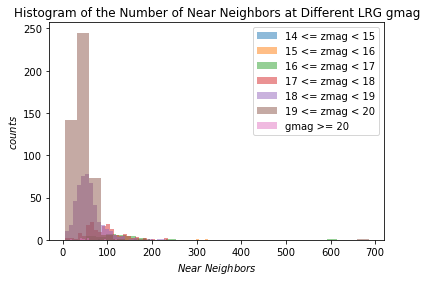

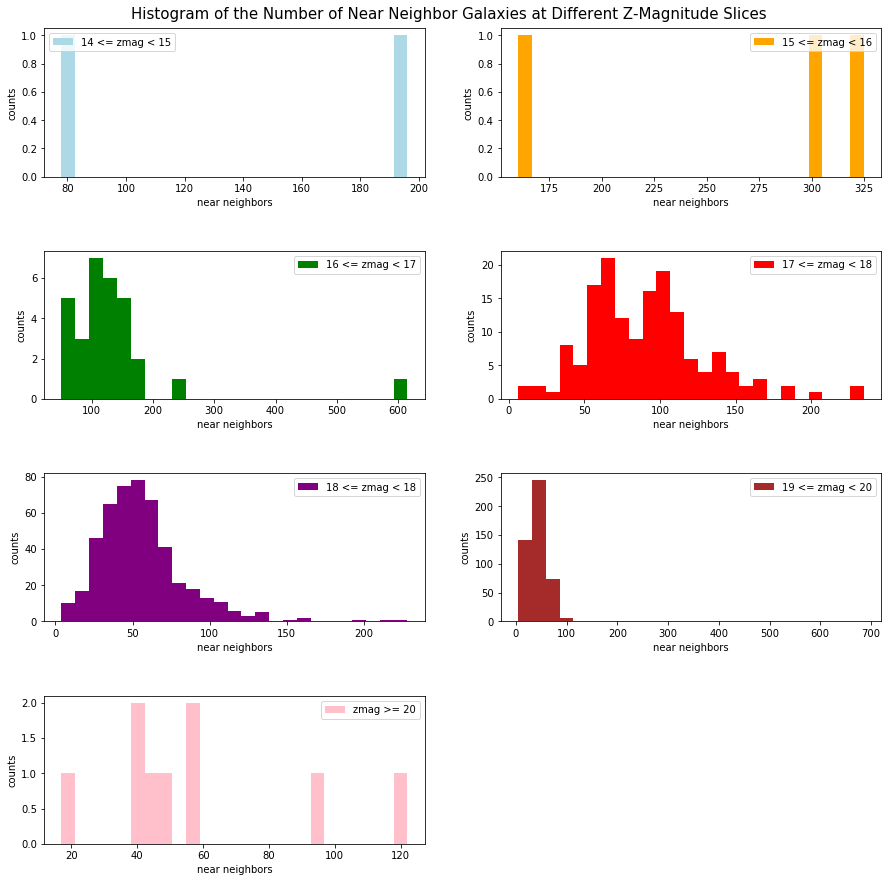

In [17]:
# Plot distribution of nn in different LRG zmag bins

zmag_LRG = np.array(zmag_LRG)
near = np.array(near)

    # bins of ~1 mag

# 14 <= zmag < 15
near1z = near[np.where((zmag_LRG >= 14.) & (15. > zmag_LRG))]
# print(len(Nsat1))

sumnear1z = []
for i in range(len(near1z)):
    sumnear1z.append(np.sum(near1z[i]))

# 15 <= zmag < 16
near2z = near[np.where((zmag_LRG >= 15.) & (16. > zmag_LRG))]
# print(len(near2g))

sumnear2z = []
for i in range(len(near2z)):
    sumnear2z.append(np.sum(near2z[i]))
# print(len(sumnear2g))
    
# 16 <= zmag < 17
near3z = near[np.where((zmag_LRG >= 16.) & (17. > zmag_LRG))]
# print(len(Nsat3))

sumnear3z = []
for i in range(len(near3z)):
    sumnear3z.append(np.sum(near3z[i]))

# 17 <= zmag < 18
near4z = near[np.where((zmag_LRG >= 17.) & (18. > zmag_LRG))]
# print(len(Nsat4))

sumnear4z = []
for i in range(len(near4z)):
    sumnear4z.append(np.sum(near4z[i]))

# 18 <= zmag < 19
near5z = near[np.where((zmag_LRG >= 18.) & (19. > zmag_LRG))]
# print(len(Nsat5))

sumnear5z = []
for i in range(len(near5z)):
    sumnear5z.append(np.sum(near5z[i]))
    
# 19 <= zmag < 20
near6z = near[np.where((zmag_LRG >= 19.) & (20. > zmag_LRG))]
# print(len(Nsat5))

sumnear6z = []
for i in range(len(near6z)):
    sumnear6z.append(np.sum(near6z[i]))

# zmag >= 20
near7z = near[np.where(zmag_LRG >= 20.)]
# print(len(Nsat8))

sumnear7z = []
for i in range(len(near7z)):
    sumnear7z.append(np.sum(near7z[i]))
    
# Calculate mean for every zmag slice
mean_sumnear1z = np.mean(sumnear1z)
print("mean number of near neighbors at 14 <= zmag < 15:", mean_sumnear1z)
mean_sumnear2z = np.mean(sumnear2z)
print("mean number of near neighbors at 15 <= zmag < 16:", mean_sumnear2z)
mean_sumnear3z = np.mean(sumnear3z)
print("mean number of near neighbors at 16 <= zmag < 17:", mean_sumnear3z)
mean_sumnear4z = np.mean(sumnear4z)
print("mean number of near neighbors at 17 <= zmag < 18:", mean_sumnear4z)
mean_sumnear5z = np.mean(sumnear5z)
print("mean number of near neighbors at 18 <= zmag < 19:", mean_sumnear5z)
mean_sumnear6z = np.mean(sumnear6z)
print("mean number of near neighbors at 19 <= zmag < 20:", mean_sumnear6z)
mean_sumnear7z = np.mean(sumnear7z)
print("mean number of near neighbors at zmag >= 20:", mean_sumnear7z)
    
print('total number of near arrays:', len(near1z) + len(near2z) + len(near3z) + len(near4z) + len(near5z) + len(near6z) + len(near7z)) 

plt.title("Histogram of the Number of Near Neighbors at Different LRG gmag")
plt.hist(sumnear1z, bins=25, alpha=0.5, label='14 <= zmag < 15')
plt.hist(sumnear2z, bins=25, alpha=0.5, label='15 <= zmag < 16')
plt.hist(sumnear3z, bins=25, alpha=0.5, label='16 <= zmag < 17')
plt.hist(sumnear4z, bins=25, alpha=0.5, label='17 <= zmag < 18')
plt.hist(sumnear5z, bins=25, alpha=0.5, label='18 <= zmag < 19')
plt.hist(sumnear6z, bins=25, alpha=0.5, label='19 <= zmag < 20')
plt.hist(sumnear7z, bins=25, alpha=0.5, label='gmag >= 20')
plt.xlabel(r'$Near$ $Neighbors$')
plt.ylabel(r'$counts$')
plt.legend(loc='upper right')
plt.show()

f, axarr = plt.subplots(4, 2, figsize=(15,15))
f.suptitle("Histogram of the Number of Near Neighbor Galaxies at Different Z-Magnitude Slices", fontsize=15, y=0.9)

axarr[0, 0].hist(sumnear1z, bins=25, color='lightblue', label='14 <= zmag < 15')
axarr[0, 0].legend(loc='upper left')
# axarr[0, 0].axvline(linewidth=1, color='black')

axarr[0, 1].hist(sumnear2z, bins=25, color='orange', label='15 <= zmag < 16')
axarr[0, 1].legend(loc='upper right')
# axarr[0, 1].axvline(linewidth=1, color='black')

axarr[1, 0].hist(sumnear3z, bins=25, color='green', label='16 <= zmag < 17')
axarr[1, 0].legend(loc='upper right')
# axarr[1, 0].axvline(linewidth=1, color='black')

axarr[1, 1].hist(sumnear4z, bins=25, color='red', label='17 <= zmag < 18')
axarr[1, 1].legend(loc='upper right')
# axarr[1, 1].axvline(linewidth=1, color='black')

axarr[2,0].hist(sumnear5z, bins=25, color='purple', label='18 <= zmag < 18')
axarr[2,0].legend(loc='upper right')
# axarr[2,0].axvline(linewidth=1, color='black')

axarr[2,1].hist(sumnear6z, bins=25, color='brown', label='19 <= zmag < 20')
axarr[2,1].legend(loc='upper right')
# axarr[2,1].axvline(linewidth=1, color='black')

axarr[3,0].hist(sumnear7z, bins=25, color='pink', label='zmag >= 20')
axarr[3,0].legend(loc='upper right')
# axarr[3,0].axvline(linewidth=1, color='black')

f.delaxes(axarr[3,1])
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.5)
# f.subplots_adjust(wspace=0.5)

for ax in axarr.flat:
    ax.set(xlabel='near neighbors', ylabel='counts')

plt.show()

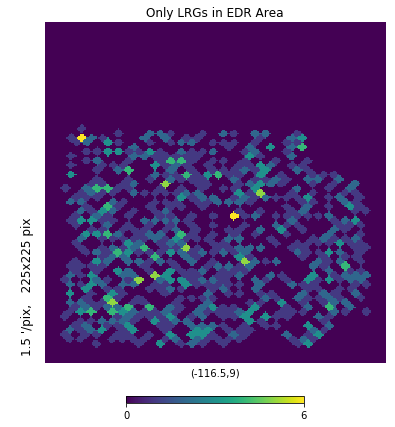

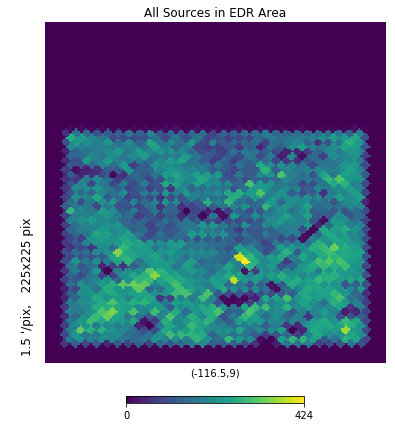

In [18]:
# Use HEALPix/Healpy to plot of sources over the sky

# add flip='geo' to make it look like the RA-Dec plot

%matplotlib inline

# ra_LRG_mag_cut = ra_LRG[np.where((gmag_LRG > 24.) & (rmag_LRG > 24.) & (zmag_LRG > 24.))]
# dec_LRG_mag_cut = dec_LRG[np.where((gmag_LRG > 24.) & (rmag_LRG > 24.) & (zmag_LRG > 24.))]

ra_BKG_mag_cut = ra_BKG[np.where((gmag_BKG < 24.) & (rmag_BKG < 24.) & (zmag_BKG < 24.))]
dec_BKG_mag_cut = dec_BKG[np.where((gmag_BKG < 24.) & (rmag_BKG < 24.) & (zmag_BKG < 24.))]

theta, phi = np.radians(90-dec_LRG), np.radians(ra_LRG)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225,flip='geo', title="Only LRGs in EDR Area")

ra = np.concatenate([ra_LRG, ra_BKG_mag_cut])
dec = np.concatenate([dec_LRG, dec_BKG_mag_cut])

theta, phi = np.radians(90-dec), np.radians(ra)
nside = 512
npixel= hp.nside2npix(nside)
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_,rot=(-116.5,9.),xsize=225, flip='geo', title="All Sources in EDR Area")

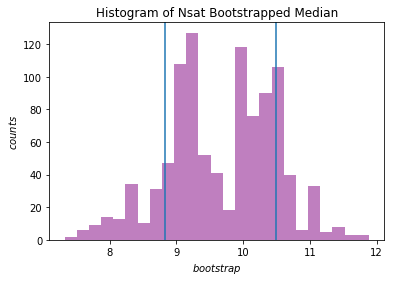

The median of Nsat: 9.84586904539
Low 68% confidence interval: 8.83585252167
High 68% confidence interval: 10.4938777319


In [20]:
# Compute bootstrap statistic for Nsat

def boot_med_plot(niter, confint, boot_func, array):

    from astropy.stats import bootstrap
    from astropy.utils import NumpyRNGContext

# niter = 1000
    with NumpyRNGContext(1):
        bootmed = bootstrap(np.asarray(array), bootnum=niter, bootfunc=boot_func)
#         bootmean = bootstrap(np.asarray(sumsat), bootnum=niter, bootfunc=np.mean)
    

# Compute confidence interval of median

#     confint = 0.68
    sortmed = sorted(bootmed)
    lowind = int(round((1 - confint)/2*niter, 2))
    highind = int(round((1-((1 - confint)/2))*niter, 2))
    
    plt.title("Histogram of Nsat Bootstrapped Median")
    plt.hist(bootmed, bins=25, color='purple', alpha=0.5)
# plt.hist(bootmean, bins=25, color='violet', alpha=0.5)
    plt.axvline(x=sortmed[lowind])
    plt.axvline(x=sortmed[highind])
    plt.xlabel(r'$bootstrap$')
    plt.ylabel(r'$counts$')
    plt.show()

    print("The median of Nsat:", np.median(array))
#     print("The mean of Nsat:", np.mean(sumsat))
    print("Low 68% confidence interval:", sortmed[lowind])
    print("High 68% confidence interval:", sortmed[highind])
    
    

boot_med_plot(1000, 0.68, np.median, sumsat)

In [52]:
import pandas as pd
from tabulate import tabulate

# x = [1,2,3,4]
# y = ['one', 'two', 'three', 'four']

# d = {'x': x, 'y': y}

sumsat = []
sumbkg = []
sumnear = []

for i in range(len(Nsat)):
    sumsat.append(np.sum(Nsat[i]))

for i in range(len(Nbkg)):
    sumbkg.append(np.sum(Nbkg[i]))
    
for i in range(len(near)):
    sumnear.append(np.sum(near[i]))


d = {'projected radius': dist, 'LRG redshift': z_lrg, 'number of satellites': sumsat, 'number of near neighbors': sumnear, 'number of interlopers': sumbkg}

# fig, ax = plt.subplots()
# fig.patch.set_visible(False)
# ax.axis('off')
# ax.axis('tight')

df = pd.DataFrame(data=d)

print(tabulate(df, headers='keys', tablefmt='latex'))

\begin{tabular}{rrrrrr}
\hline
      &   LRG redshift &   number of interlopers &   number of near neighbors &   number of satellites &   projected radius \\
\hline
    0 &       0.564547 &                 34.7052 &                         42 &              7.29478   &          0.0211488 \\
    1 &       0.565658 &                 34.6382 &                         40 &              5.36184   &          0.0211284 \\
    2 &       0.629988 &                 31.3014 &                         27 &             -4.3014    &          0.0200849 \\
    3 &       0.397492 &                 51.245  &                         48 &             -3.24502   &          0.0256989 \\
    4 &       0.252465 &                 94.9062 &                        138 &             43.0938    &          0.0349732 \\
    5 &       0.234743 &                105.776  &                        147 &             41.2236    &          0.0369218 \\
    6 &       0.718574 &                 28.0161 &                       

In [49]:
# Counting the LOCAL BACKGROUND using KDTree
# Result is an array of the number of near neighbors each LRG has

ra_BKG = ra_ALL[np.where(no_LRG_cut)]
dec_BKG = dec_ALL[np.where(no_LRG_cut)]

# Distance from which we are looking for satellites around the LRGs
local_distance = 5. # in Mpc
local_distance_kpc = distance * 10.**3. # in kpc

local_dist = []
for i in range(len(kpc_DA)):
    local_dist.append((local_distance_kpc / kpc_DA[i]) * 1./3600.) 
    
# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
zip_list_LRG = list(zip(ra_LRG, dec_LRG)) # Fake LRG sources
zip_list_BKG = list(zip(ra_BKG, dec_BKG)) # Fake EDR sources

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list_BKG)

# returns a list of EDR sources that are within some radius r of an LRG
local_nn = gal_tree.query_radius(zip_list_LRG,r=local_dist,count_only=True)

# find indices of near neighbors
# creates a list of arrays that include the indices of satellite galaxies per LRG. In general, some or all of these
# arrays could be empty
local_ind = gal_tree.query_radius(zip_list_LRG,r=local_dist)
# print(ind)
# print(type(ind[5]))
# ind5 = ind[0]
# print(ind5)
# print(type(ind5[0]))

# Creates one list of number of near neighbors for every LRG (number of lists = number of LRGs)
# LOCAL_BKG is the list of 2D arrays of survey galaxies as a funciton of color and magnitude
local_bkg = []

for i in range(len(local_ind)):
    # Creates a zero array if there are no near neighbors
    if len(ind[i]) == 0:
        hist2d = np.zeros((len(xedges)-1,len(yedges)-1))
        local_bkg.append(hist2d)
    # Creates a 2D histogram for satellite galaxies
    else:
        hist2d, x_notuse, y_notuse = np.histogram2d(rmag_BKG[local_ind[i]], color_BKG[local_ind[i]], bins=(xedges, yedges), normed=False)
        local_bkg.append(hist2d)

print(len(local_bkg))

1151


535
686
242.625868989
7.56479443502
0.08984


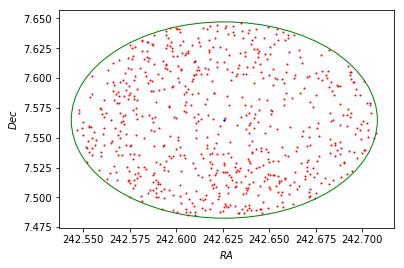

535
-5715650914.0
0.08984
242.625868989
7.56479443502


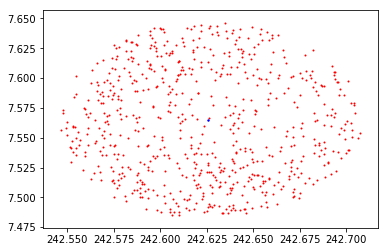

In [52]:
print(np.argmax(local_nn))
print(len(local_ind[np.argmax(local_nn)]))
print(ra_LRG[np.argmax(local_nn)])
print(dec_LRG[np.argmax(local_nn)])
print(z_LRG[np.argmax(local_nn)])

plt.scatter(ra_BKG[local_ind[np.argmax(local_nn)]], dec_BKG[local_ind[np.argmax(local_nn)]], color="red", s=1)
plt.scatter(ra_LRG[np.argmax(local_nn)], dec_LRG[np.argmax(local_nn)], color="blue", s=2)

circle = plt.Circle((ra_LRG[np.argmax(local_nn)],dec_LRG[np.argmax(local_nn)]), dist[np.argmax(local_nn)], color='green', fill=False)
plt.gcf().gca().add_artist(circle)

plt.xlabel(r'$RA$')
plt.ylabel(r'$Dec$')
plt.show()

# plt.show()

print(np.argmin(sumsat))
print(sumsat[np.argmin(sumsat)])
print(z_LRG[np.argmin(sumsat)])
print(ra_LRG[np.argmin(sumsat)])
print(dec_LRG[np.argmin(sumsat)])

plt.scatter(ra_BKG[local_ind[np.argmin(sumsat)]], dec_BKG[local_ind[np.argmin(sumsat)]], color="red", s=1)
plt.scatter(ra_LRG[np.argmin(sumsat)], dec_LRG[np.argmin(sumsat)], color="blue", s=2)
plt.show()

# plt.scatter(ra_BKG[local_ind[np.argmin(local_nn)]], dec_BKG[local_ind[np.argmin(local_nn)]], color="red", s=1)
# plt.scatter(ra_LRG[np.argmin(local_nn)], dec_LRG[np.argmin(local_nn)], color="blue", s=2)
# plt.show()

In [ ]:
r = []
for i in range(len(kpc_DA)):
    r.append((local_distance_kpc / kpc_DA[i]) * (1./3600.))
    
sigma = []
for i in range(len(local_bkg)):
    sigma.append(local_bkg[i] / (np.pi * r[i]**2.))
    
Nbkg = []
Nbkg = sigma * omega